In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import gc
print(os.listdir("../input"))

['train_identity.csv', 'test_identity.csv', 'test_transaction.csv', 'sample_submission.csv', 'train_transaction.csv']


In [2]:
# credit to @guiferviz for the memory reduction 
def memory_usage_mb(df, *args, **kwargs):
    """Dataframe memory usage in MB. """
    return df.memory_usage(*args, **kwargs).sum() / 1024**2

def reduce_memory_usage(df, deep=True, verbose=True):
    # All types that we want to change for "lighter" ones.
    # int8 and float16 are not include because we cannot reduce
    # those data types.
    # float32 is not include because float16 has too low precision.
    numeric2reduce = ["int16", "int32", "int64", "float64"]
    start_mem = 0
    if verbose:
        start_mem = memory_usage_mb(df, deep=deep)

    for col, col_type in df.dtypes.iteritems():
        best_type = None
        if col_type in numeric2reduce:
            downcast = "integer" if "int" in str(col_type) else "float"
            df[col] = pd.to_numeric(df[col], downcast=downcast)
            best_type = df[col].dtype.name
        # Log the conversion performed.
        if verbose and best_type is not None and best_type != str(col_type):
            print(f"Column '{col}' converted from {col_type} to {best_type}")

    if verbose:
        end_mem = memory_usage_mb(df, deep=deep)
        diff_mem = start_mem - end_mem
        percent_mem = 100 * diff_mem / start_mem
        print(f"Memory usage decreased from"
              f" {start_mem:.2f}MB to {end_mem:.2f}MB"
              f" ({diff_mem:.2f}MB, {percent_mem:.2f}% reduction)")
        
    return df

In [3]:
train_identity_data = pd.read_csv('../input/train_identity.csv')
train_transaction_data = pd.read_csv('../input/train_transaction.csv')

In [4]:
pd.set_option('display.max_columns', 500)
train_transaction_data.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [5]:
train_identity_data.head(5)

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [6]:
# https://www.kaggle.com/fchmiel/day-and-time-powerful-predictive-feature
train_transaction_data['Transaction_dow'] = np.floor((train_transaction_data['TransactionDT'] / (3600 * 24) - 1) % 7)
train_transaction_data['Transaction_hour'] = np.floor(train_transaction_data['TransactionDT'] / 3600) % 24

In [7]:
na_columns = train_identity_data.isna().sum()
print(na_columns[na_columns==0])
print(na_columns[na_columns>0]/train_identity_data.shape[0])

TransactionID    0
id_01            0
id_12            0
dtype: int64
id_02         0.023303
id_03         0.540161
id_04         0.540161
id_05         0.051084
id_06         0.051084
id_07         0.964259
id_08         0.964259
id_09         0.480521
id_10         0.480521
id_11         0.022568
id_13         0.117262
id_14         0.445037
id_15         0.022519
id_16         0.103257
id_17         0.033723
id_18         0.687221
id_19         0.034077
id_20         0.034472
id_21         0.964231
id_22         0.964162
id_23         0.964162
id_24         0.967088
id_25         0.964419
id_26         0.964204
id_27         0.964162
id_28         0.022568
id_29         0.022568
id_30         0.462224
id_31         0.027393
id_32         0.462079
id_33         0.491871
id_34         0.460560
id_35         0.022519
id_36         0.022519
id_37         0.022519
id_38         0.022519
DeviceType    0.023732
DeviceInfo    0.177262
dtype: float64


In [8]:
print(train_identity_data.dtypes)

TransactionID      int64
id_01            float64
id_02            float64
id_03            float64
id_04            float64
id_05            float64
id_06            float64
id_07            float64
id_08            float64
id_09            float64
id_10            float64
id_11            float64
id_12             object
id_13            float64
id_14            float64
id_15             object
id_16             object
id_17            float64
id_18            float64
id_19            float64
id_20            float64
id_21            float64
id_22            float64
id_23             object
id_24            float64
id_25            float64
id_26            float64
id_27             object
id_28             object
id_29             object
id_30             object
id_31             object
id_32            float64
id_33             object
id_34             object
id_35             object
id_36             object
id_37             object
id_38             object
DeviceType        object


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
# number of nan values in each column
pd.set_option('display.max_rows', 500)
na_columns = train_transaction_data.isna().sum()
print(na_columns[na_columns==0])
print(na_columns[na_columns>0]/train_transaction_data.shape[0])

TransactionID       0
isFraud             0
TransactionDT       0
TransactionAmt      0
ProductCD           0
card1               0
C1                  0
C2                  0
C3                  0
C4                  0
C5                  0
C6                  0
C7                  0
C8                  0
C9                  0
C10                 0
C11                 0
C12                 0
C13                 0
C14                 0
Transaction_dow     0
Transaction_hour    0
dtype: int64
card2            0.015127
card3            0.002650
card4            0.002670
card5            0.007212
card6            0.002660
addr1            0.111264
addr2            0.111264
dist1            0.596524
dist2            0.936284
P_emaildomain    0.159949
R_emaildomain    0.767516
D1               0.002149
D2               0.475492
D3               0.445149
D4               0.286047
D5               0.524674
D6               0.876068
D7               0.934099
D8               0.873123
D9       

The categorical columns in identity data are:  ['DeviceType', 'id_16', 'id_29', 'id_23', 'id_38', 'DeviceInfo', 'id_33', 'id_35', 'id_36', 'id_27', 'id_30', 'id_37', 'id_28', 'id_31', 'id_34', 'id_15', 'id_12']


/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


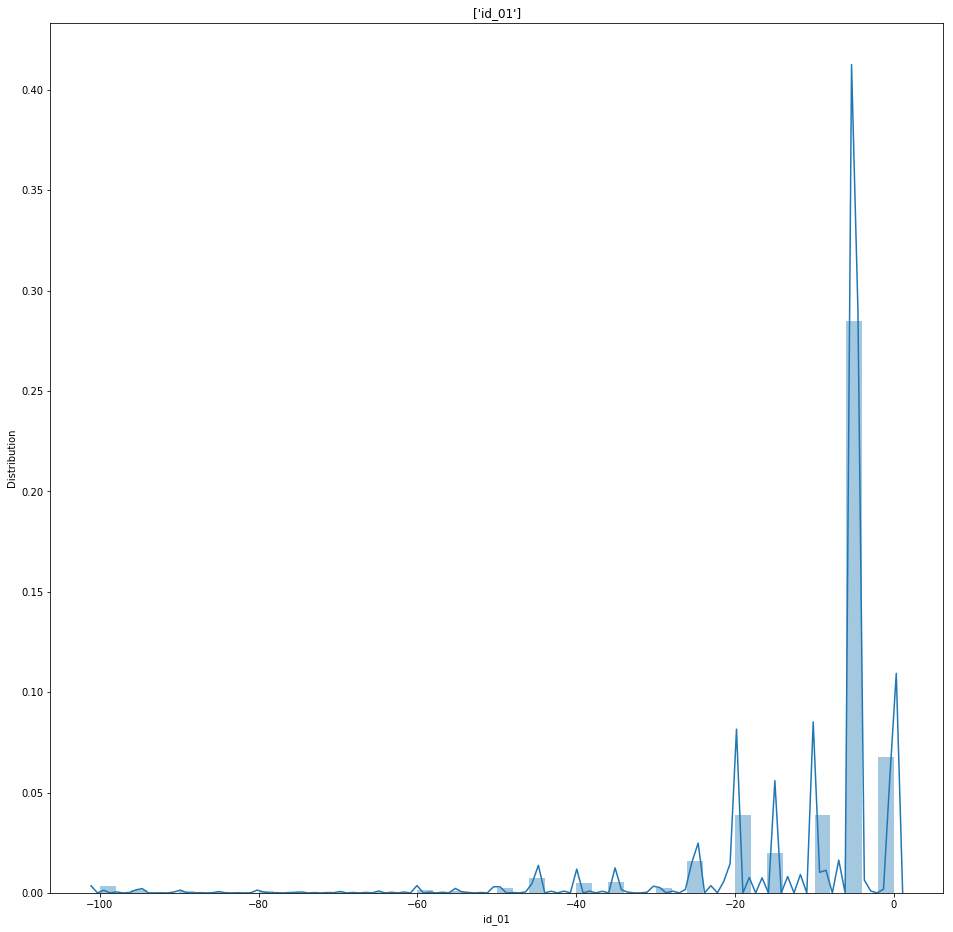

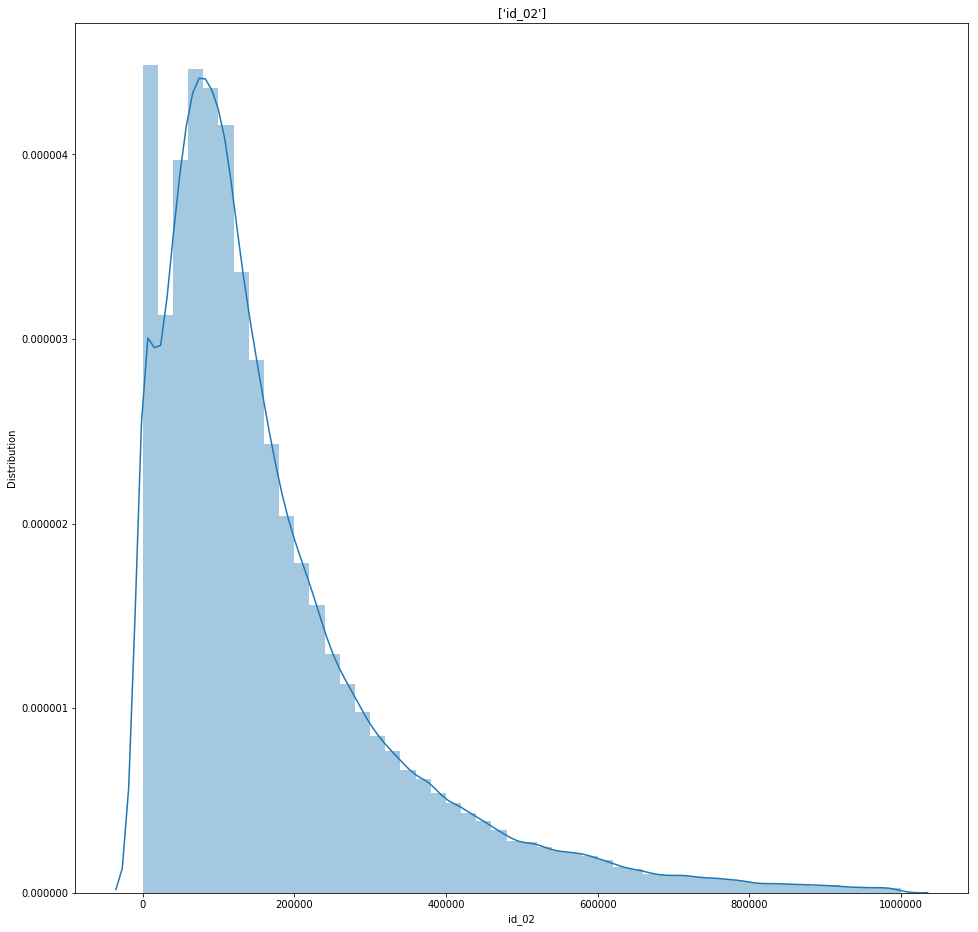

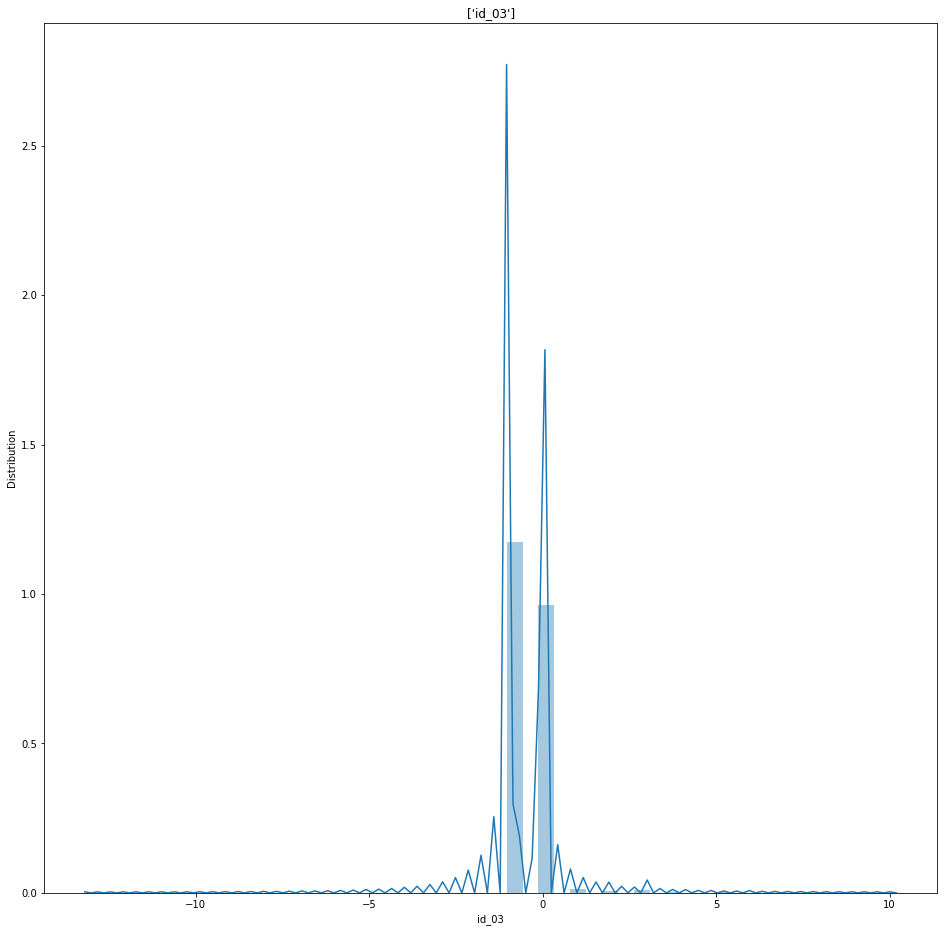

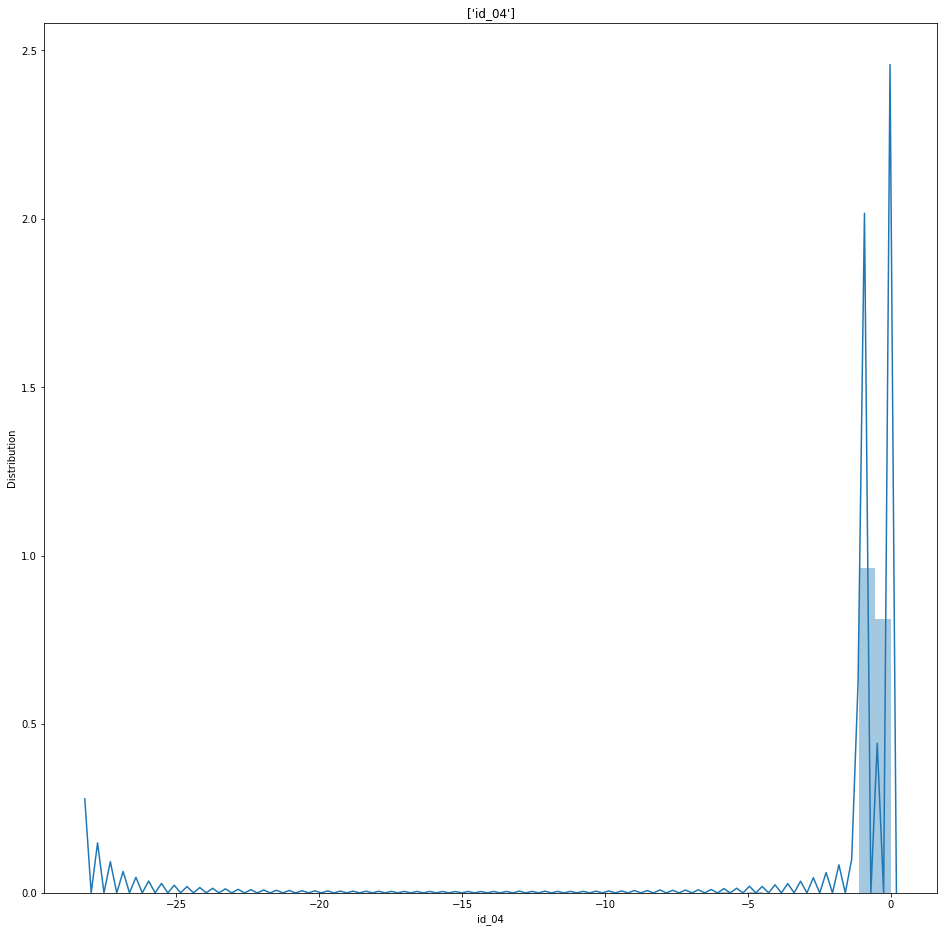

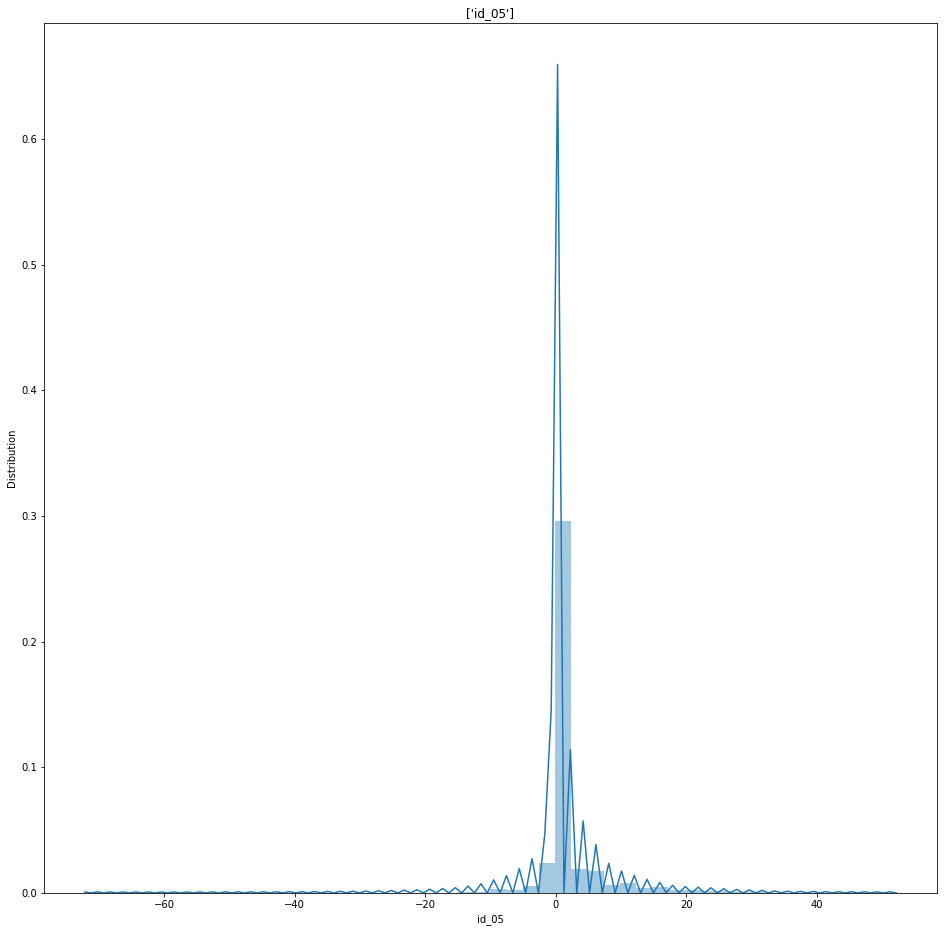

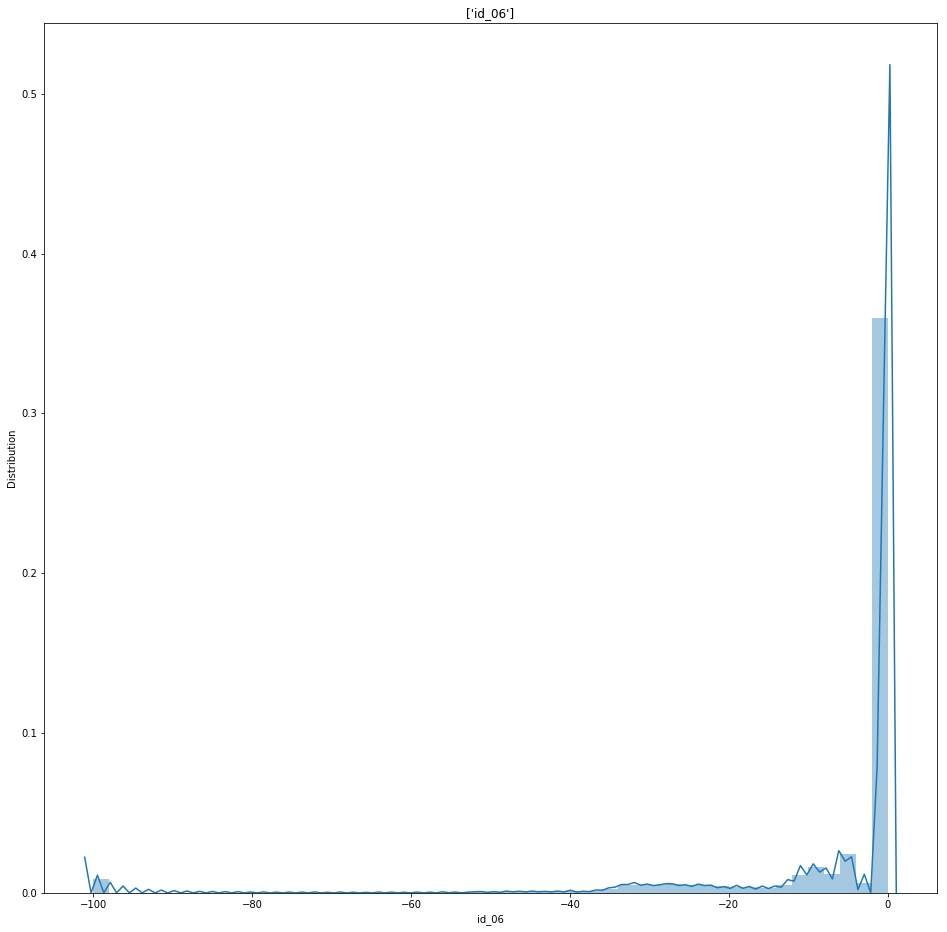

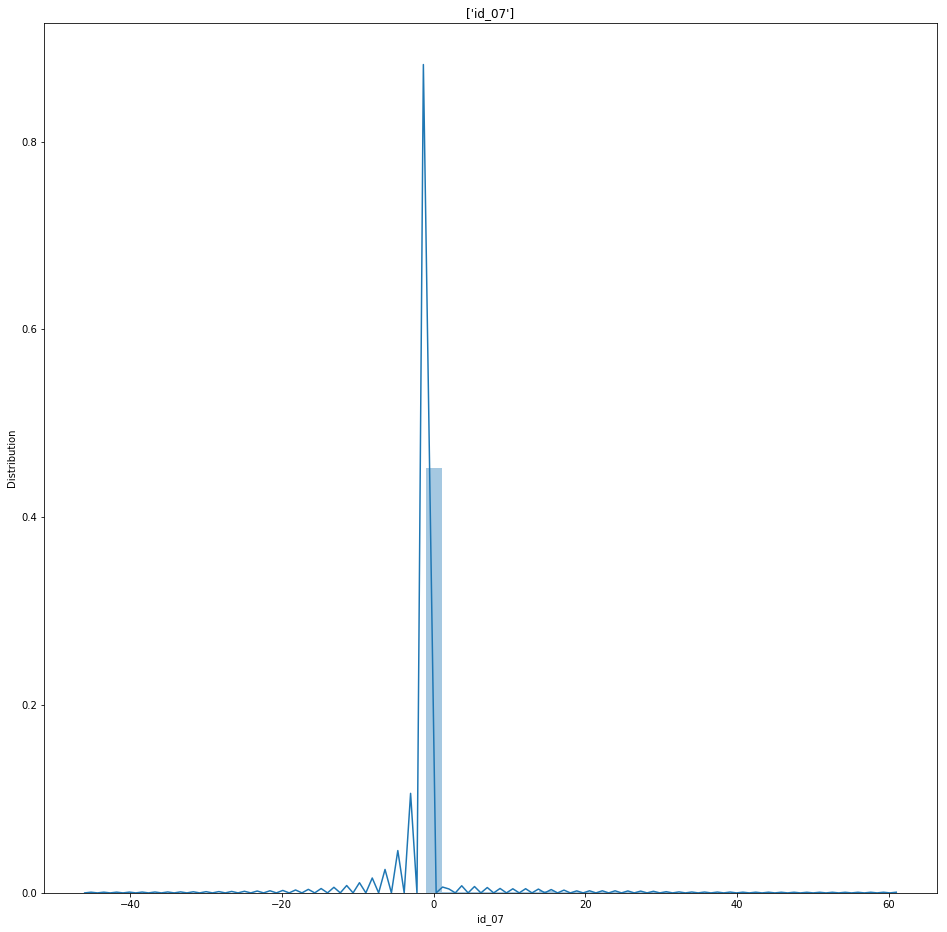

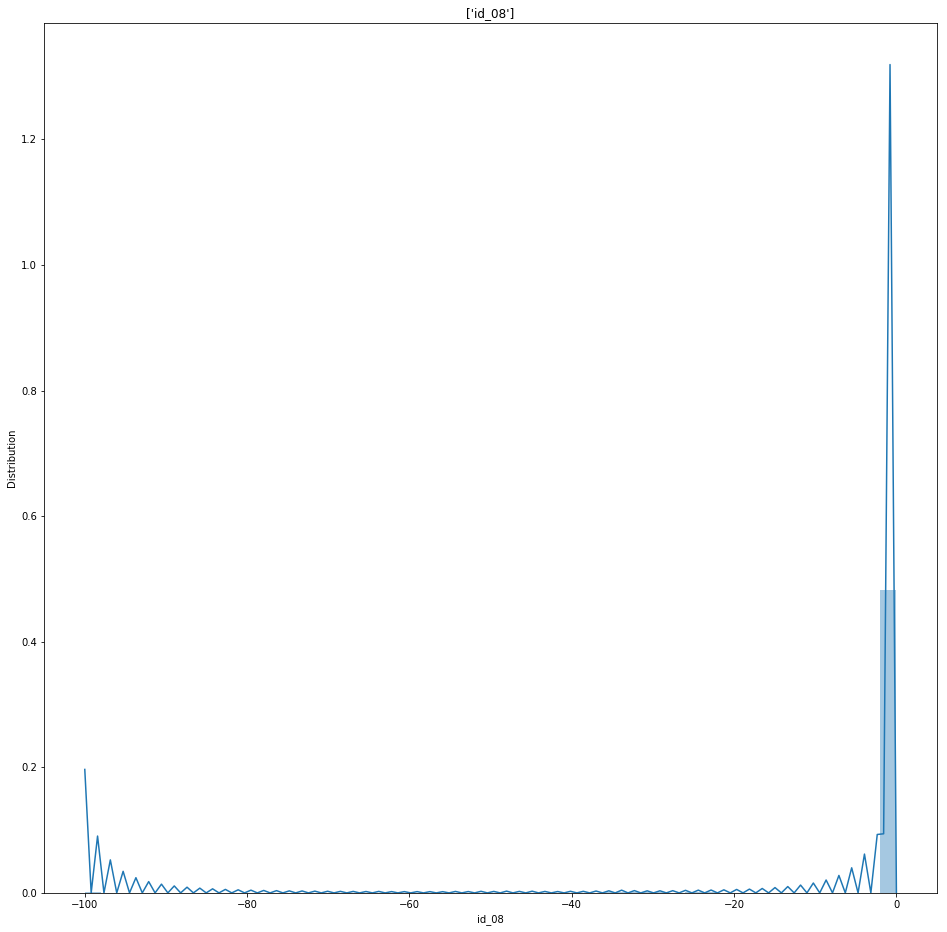

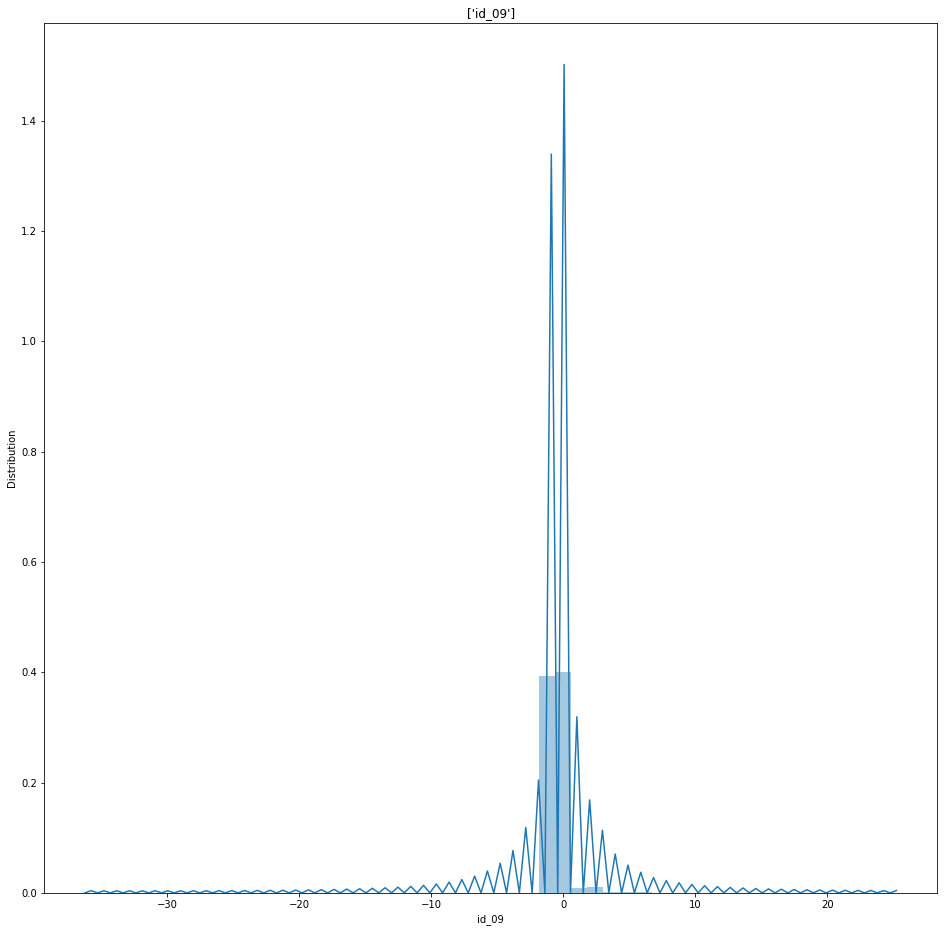

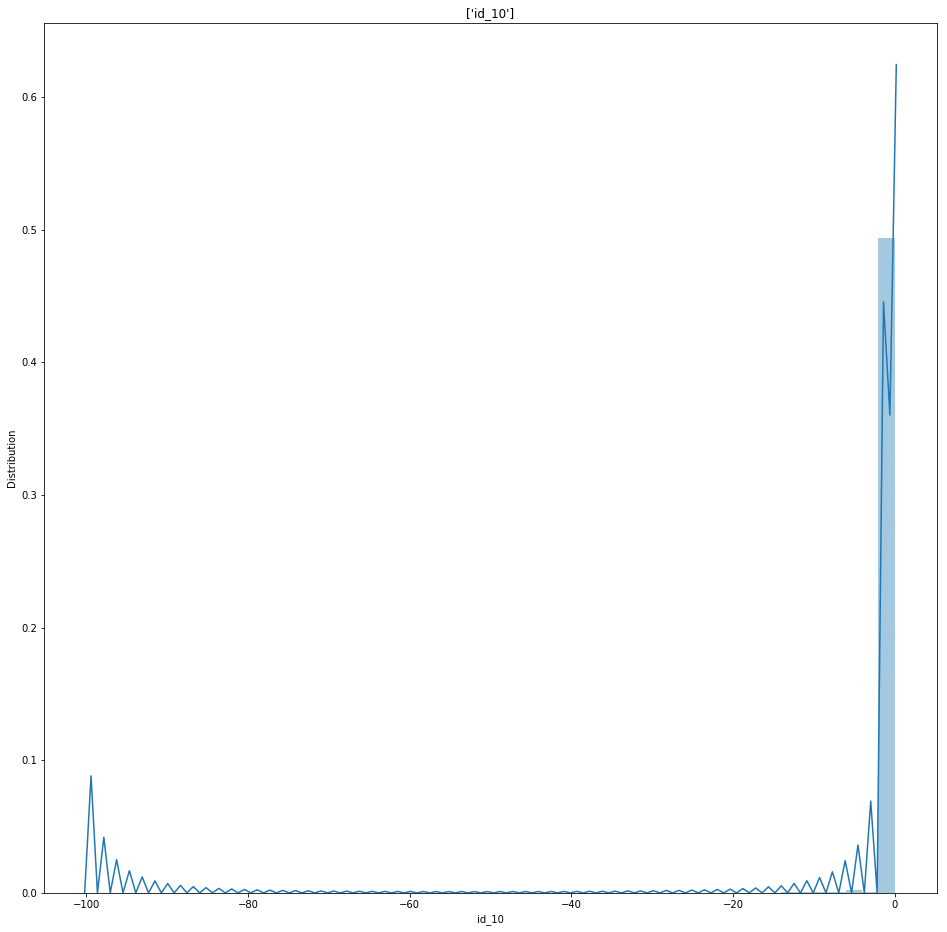

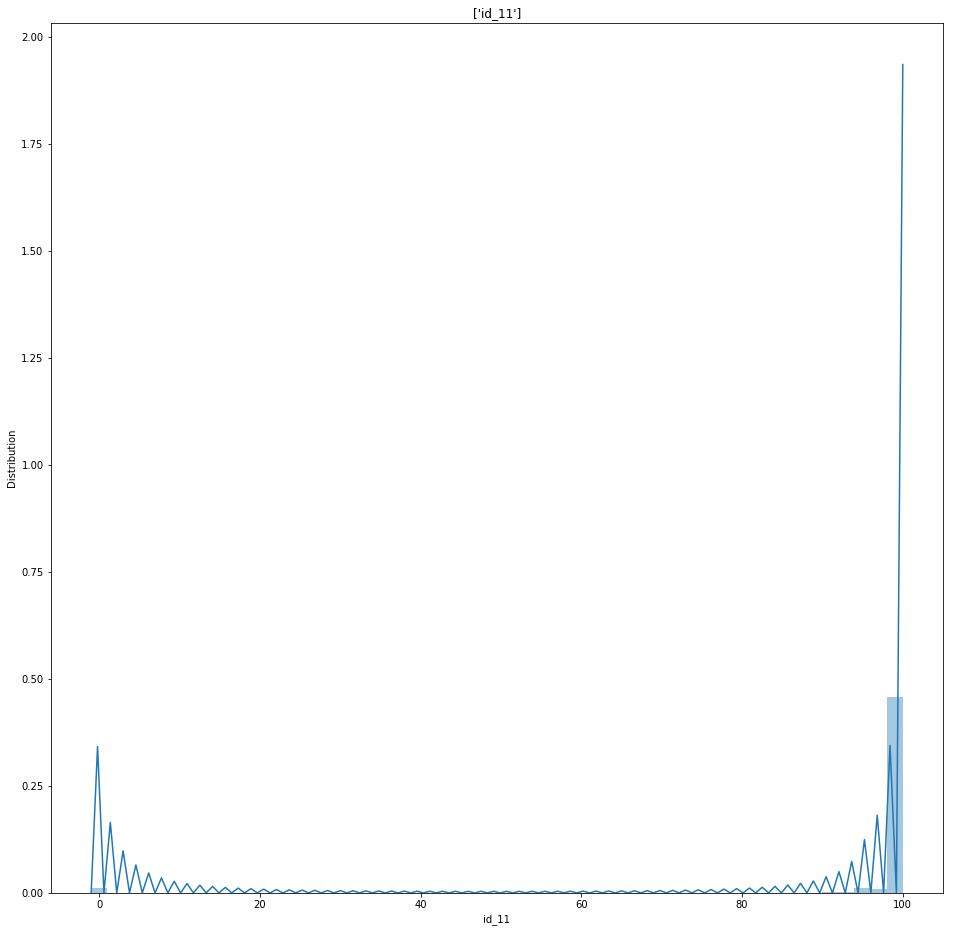

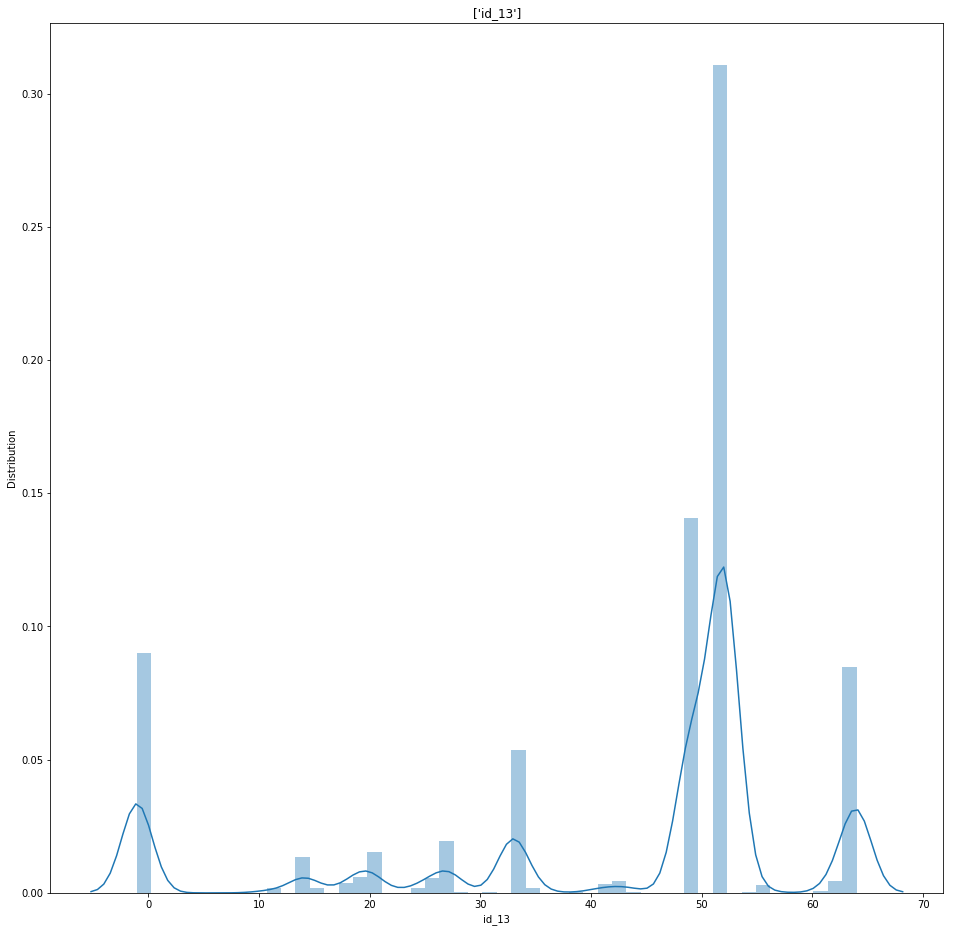

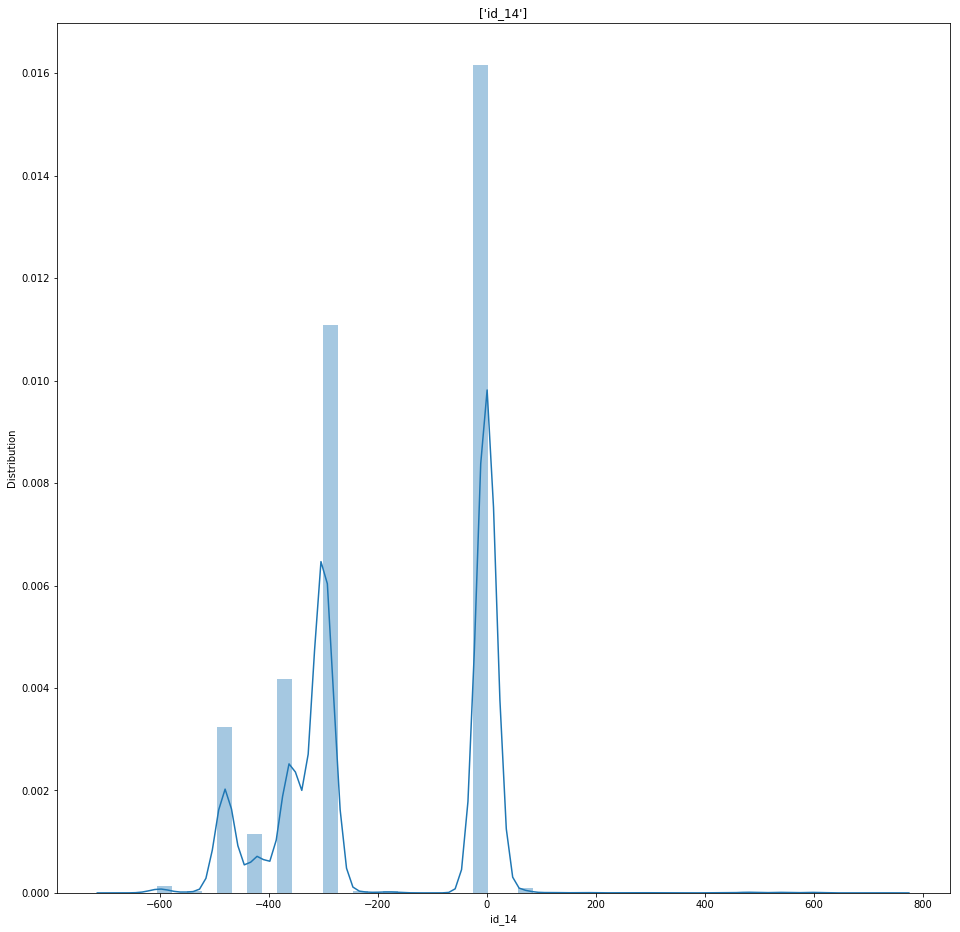

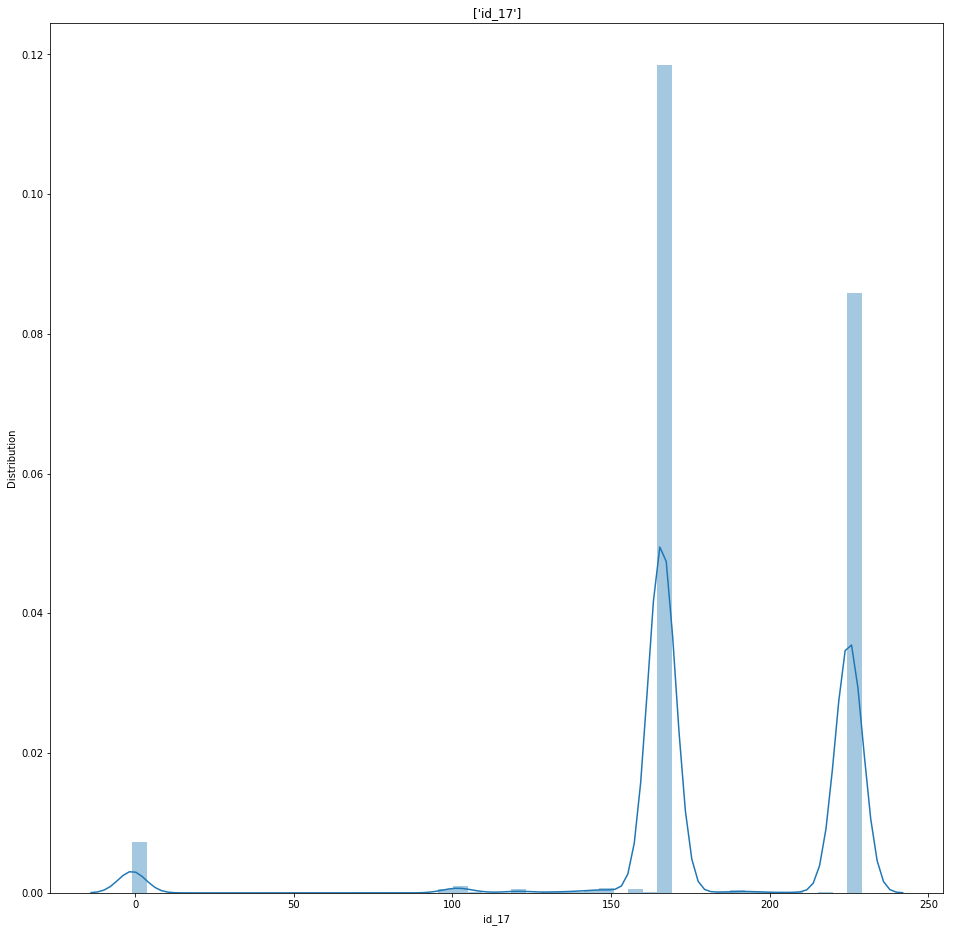

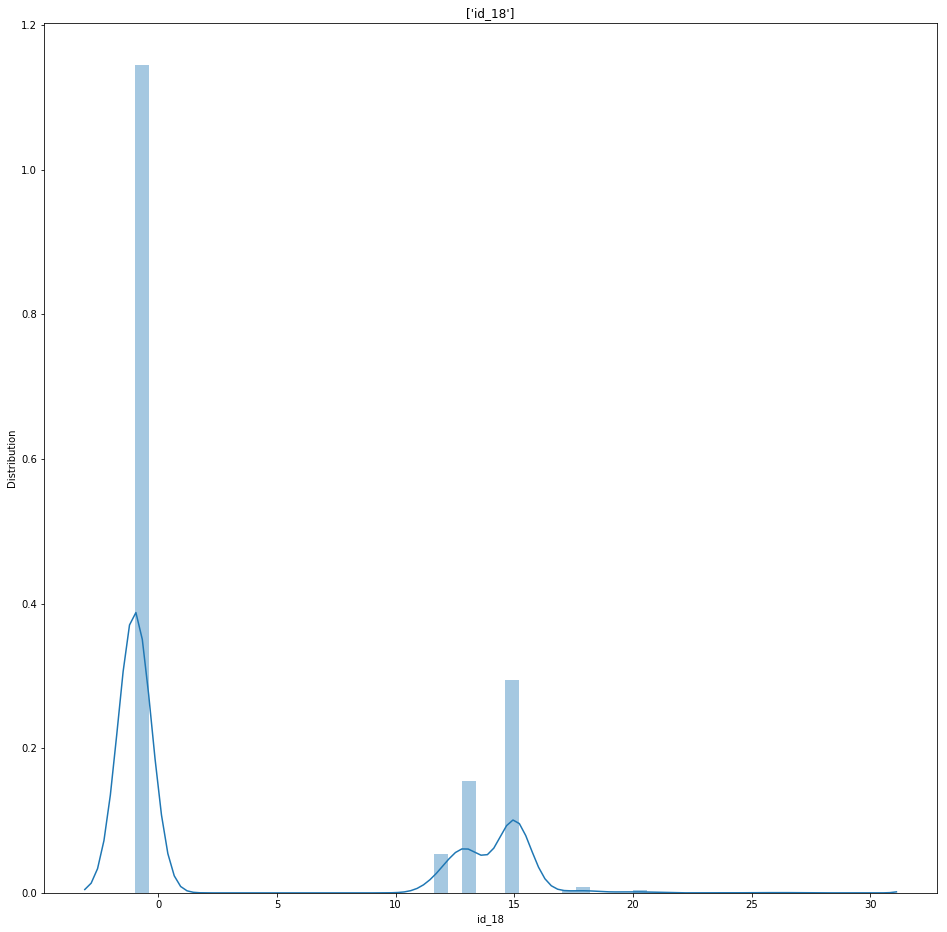

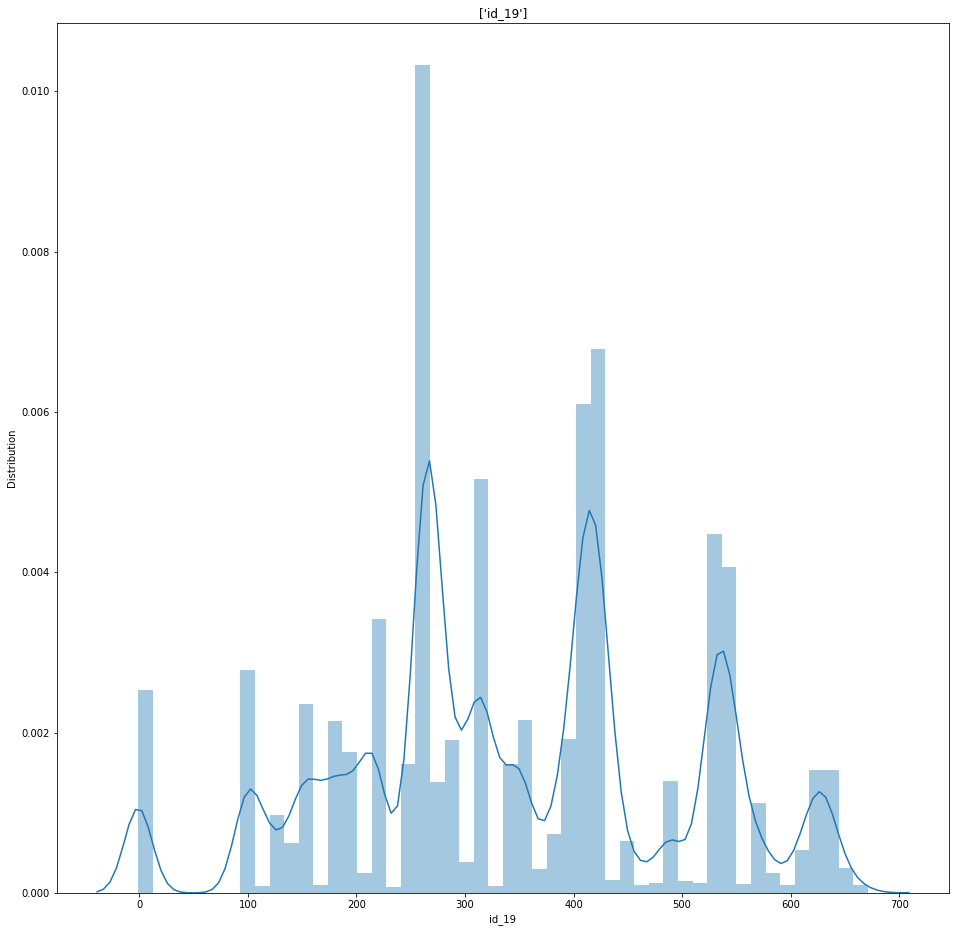

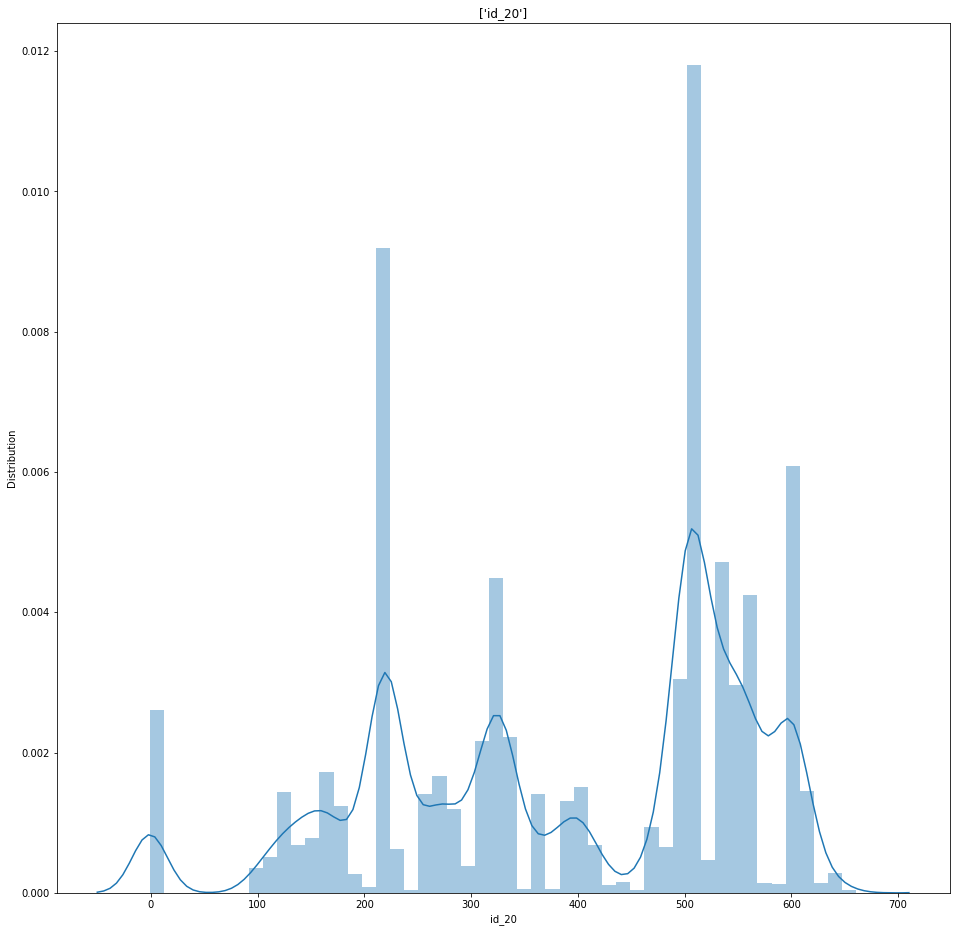

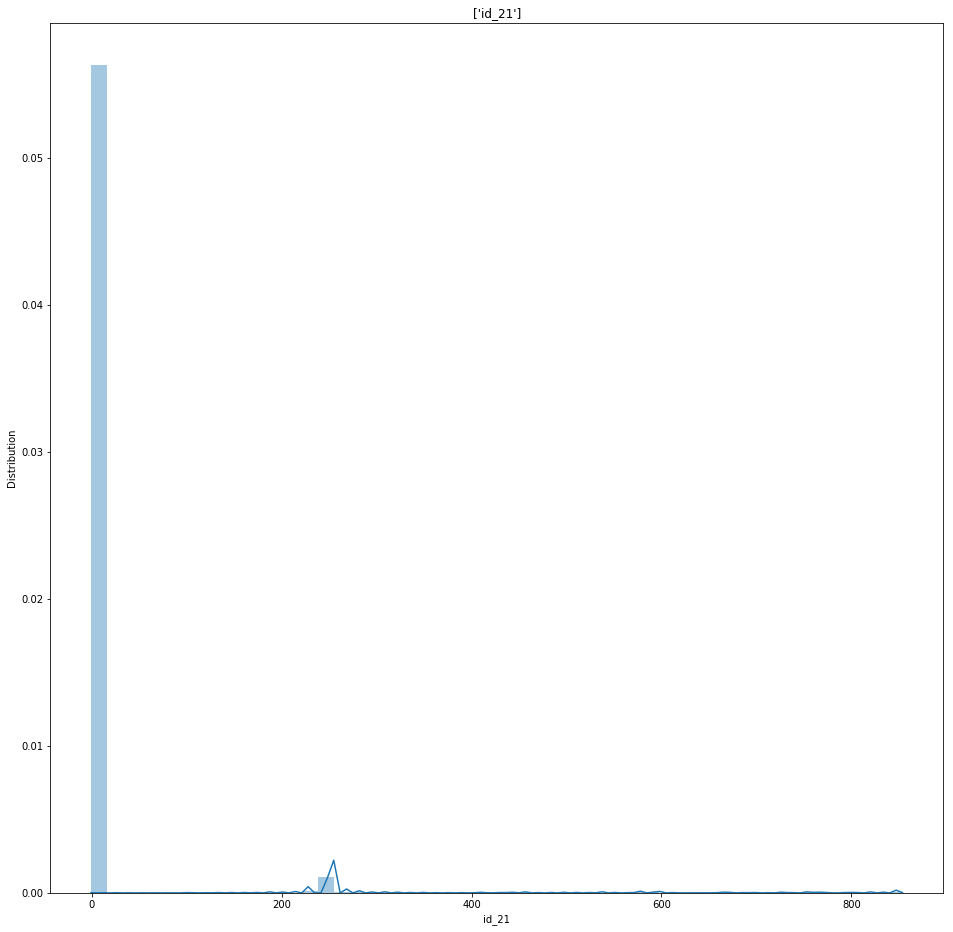

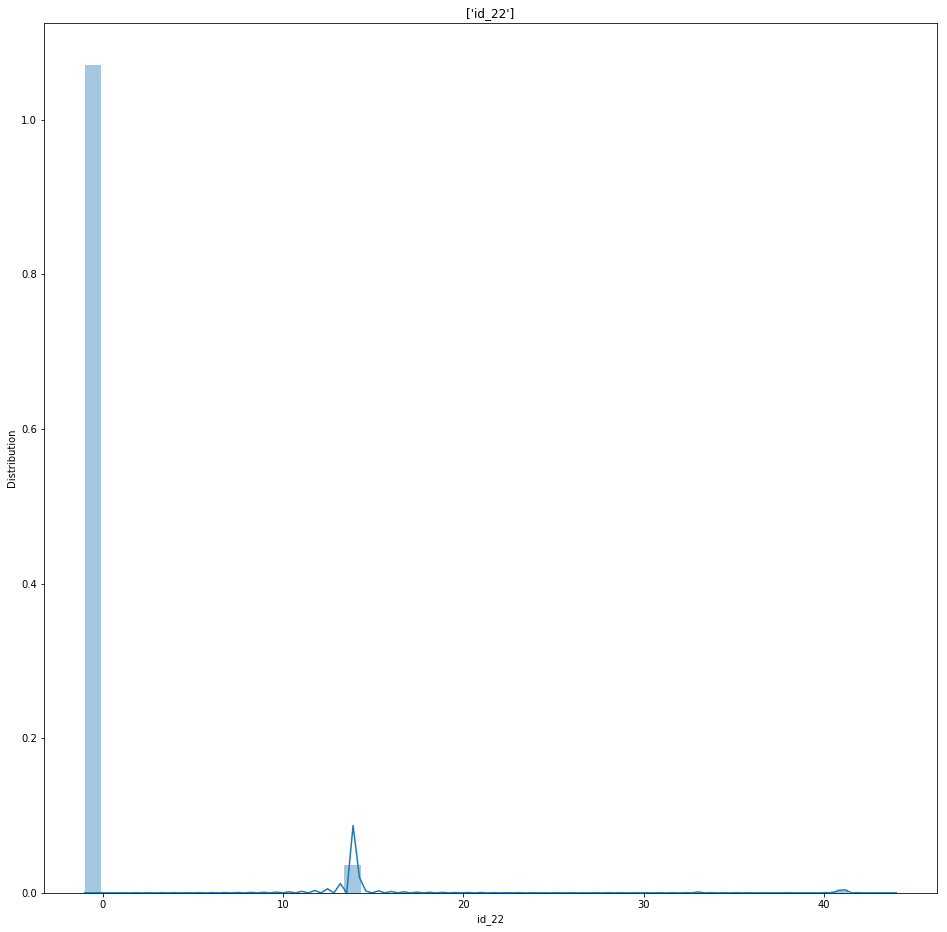

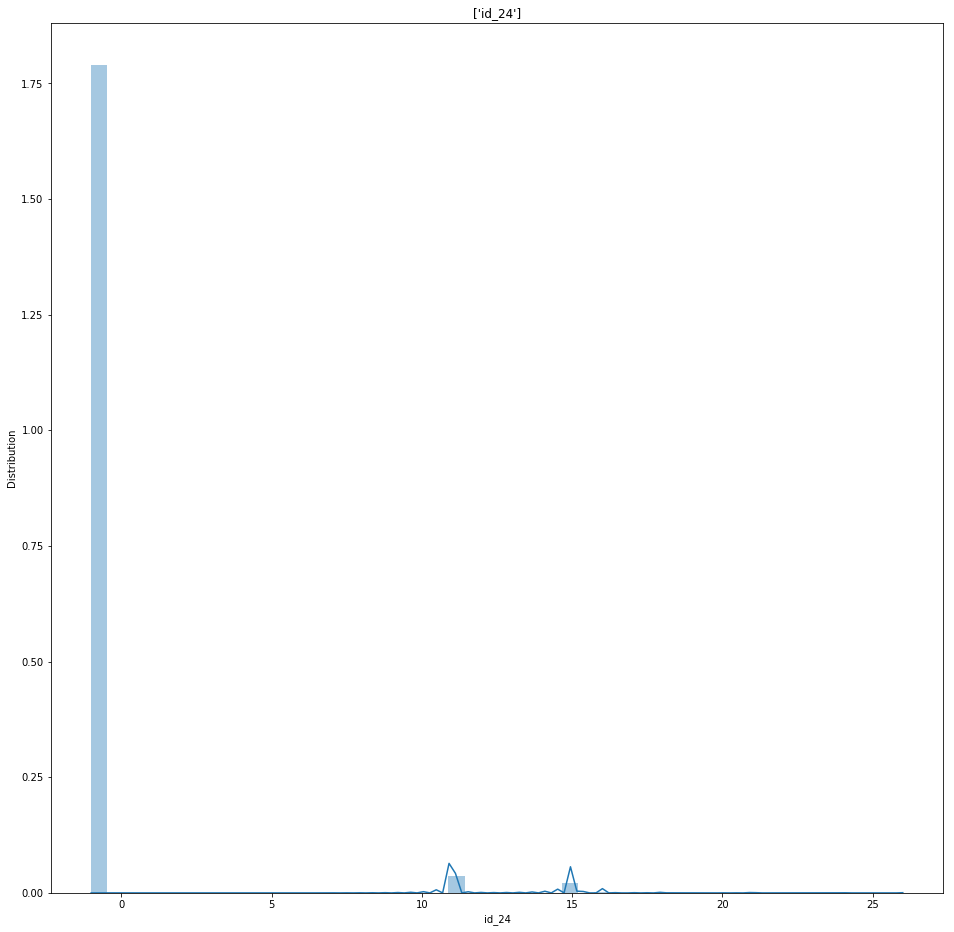

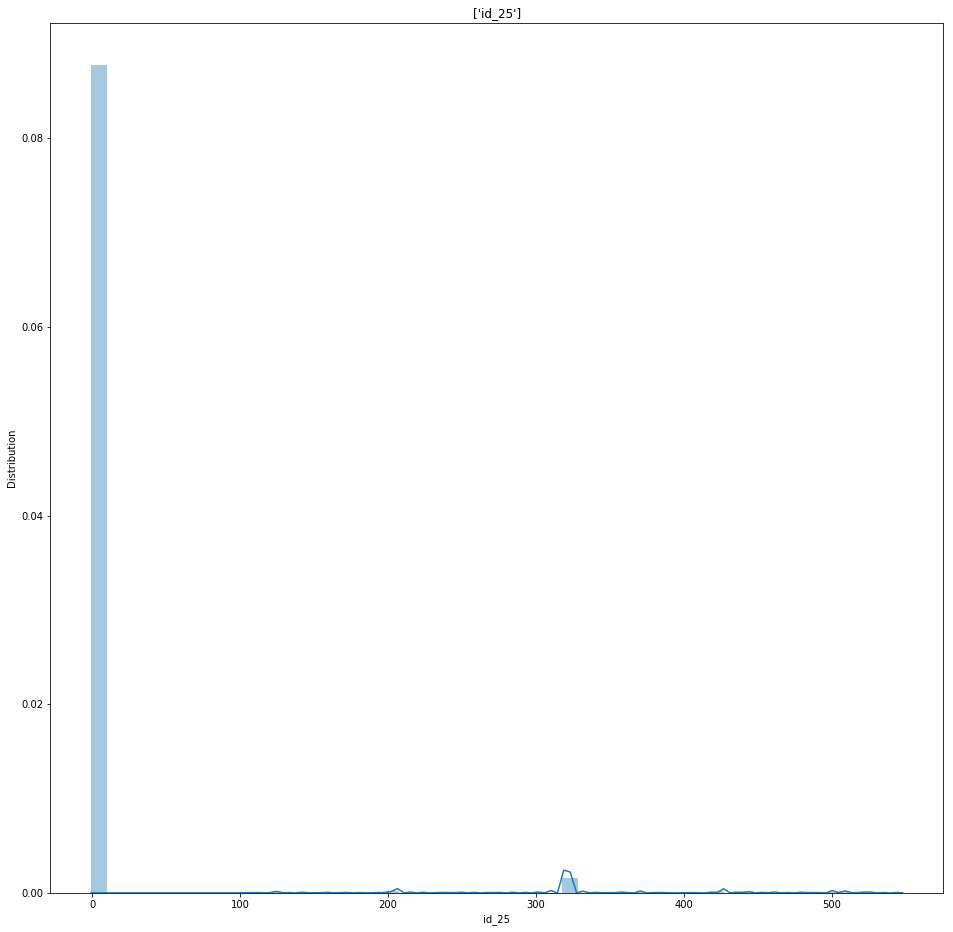

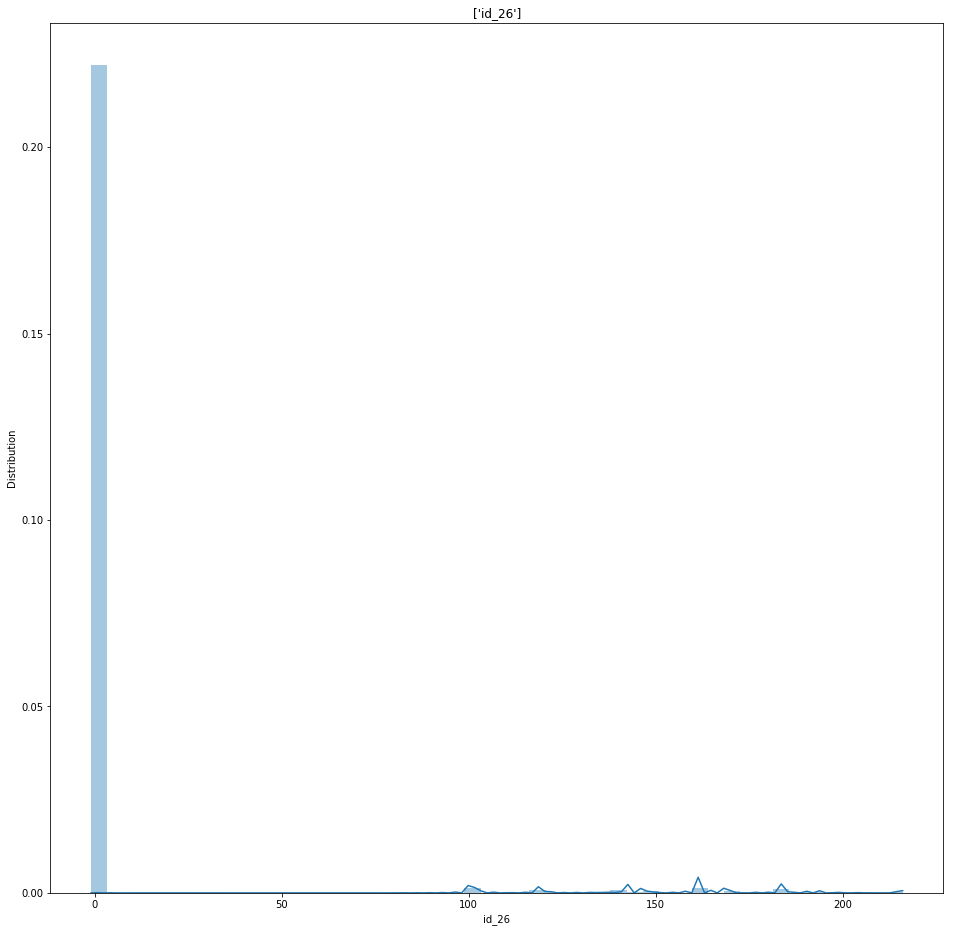

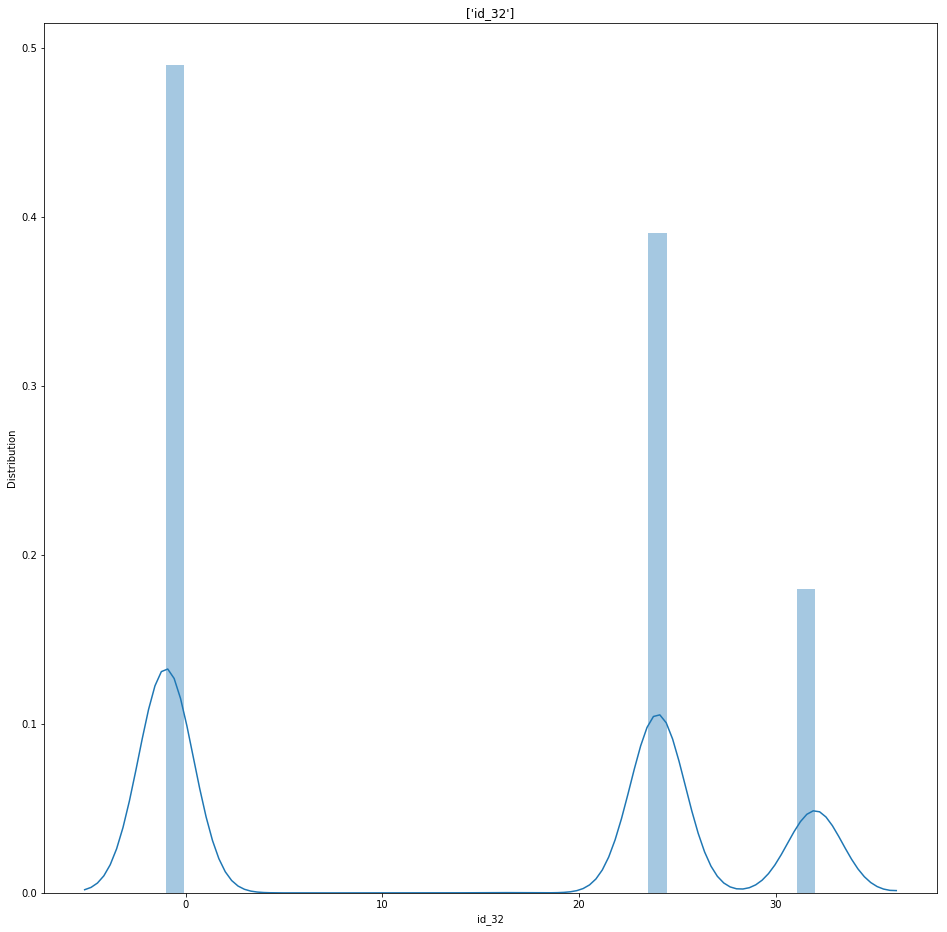

In [11]:
identity_data_columns = train_identity_data.columns
numericCols = train_identity_data._get_numeric_data().columns
categoricalCols = list(set(identity_data_columns) - set(numericCols))
print('The categorical columns in identity data are: ',categoricalCols)
train_identity_data[categoricalCols] = train_identity_data[categoricalCols].replace({ np.nan:'missing'})
train_identity_data[numericCols] = train_identity_data[numericCols].replace({ np.nan:-1})
colstoplot = ['id_01','id_02','id_03','id_04','id_05','id_06','id_07','id_08','id_09','id_10',
              'id_11','id_13','id_14','id_17','id_18','id_19','id_20','id_21','id_22','id_24','id_25','id_26','id_32']
for i in colstoplot:  
    plt.figure(figsize=(16, 16))
    ax = sns.distplot(eval('train_identity_data["'+i+'"]'))
    ax.set(ylabel="Distribution")
    ax.set_title([i])    

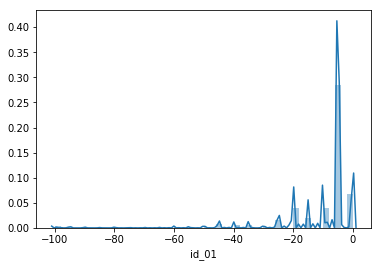

In [12]:
sns.distplot(train_identity_data['id_01'])

In [13]:
transaction_data_columns = train_transaction_data.columns
numericCols = train_transaction_data._get_numeric_data().columns
categoricalCols = list(set(transaction_data_columns) - set(numericCols))
print('The categorical columns in transaction data are: ',categoricalCols)

The categorical columns in transaction data are:  ['M1', 'M3', 'M2', 'P_emaildomain', 'ProductCD', 'M5', 'R_emaildomain', 'card6', 'M6', 'M9', 'card4', 'M4', 'M8', 'M7']


In [14]:
train_transaction_data[categoricalCols] = train_transaction_data[categoricalCols].replace({ np.nan:'missing'})
train_transaction_data[numericCols] = train_transaction_data[numericCols].replace({ np.nan:-1})

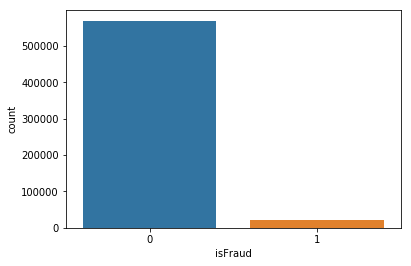

In [15]:
sns.countplot(train_transaction_data['isFraud'])

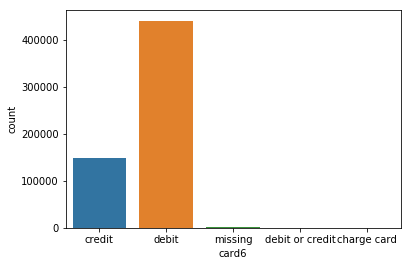

In [16]:
sns.countplot(train_transaction_data['card6'])

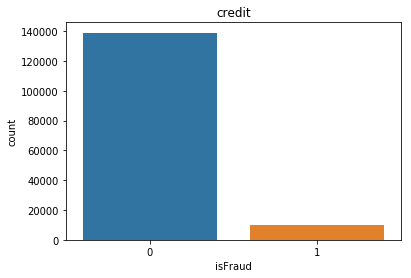

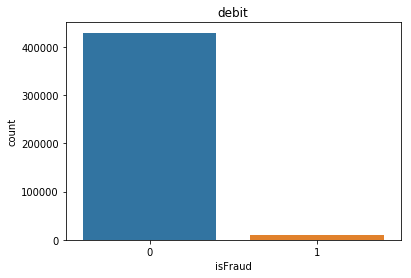

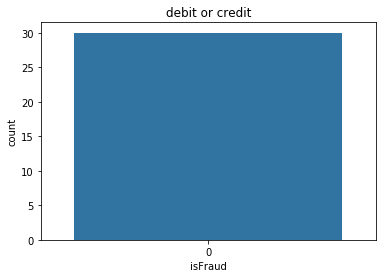

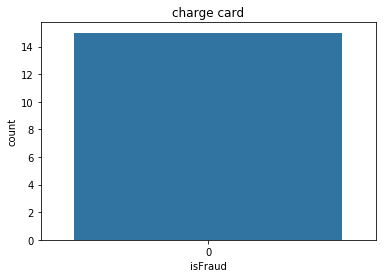

In [17]:
cardTypes = ['credit','debit','debit or credit','charge card']
for i,i_card in enumerate(cardTypes):
    cardData = eval('train_transaction_data.loc[train_transaction_data["card6"]=="'+i_card+'"]')
    plt.figure(i)
    sns.countplot(cardData['isFraud']).set_title(i_card)

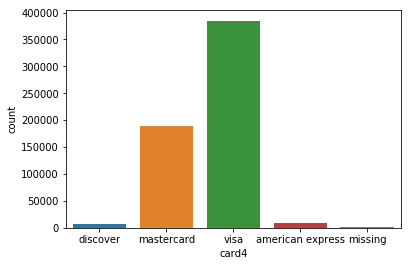

In [18]:
sns.countplot(train_transaction_data['card4'])

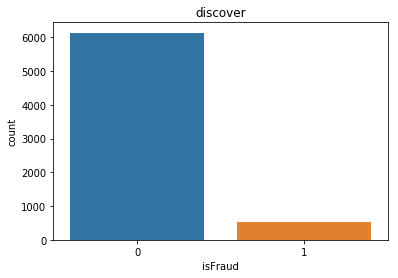

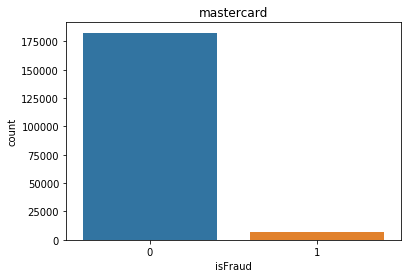

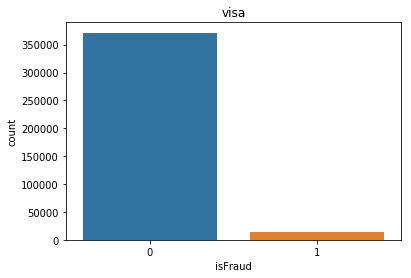

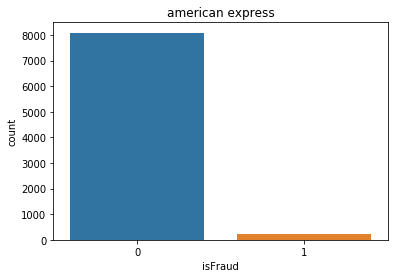

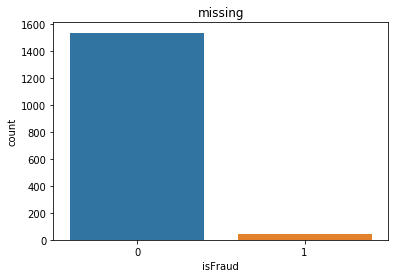

In [19]:
cardTypes = ['discover','mastercard','visa','american express','missing']
for i,i_card in enumerate(cardTypes):
    cardData = eval('train_transaction_data.loc[train_transaction_data["card4"]=="'+i_card+'"]')
    plt.figure(i)
    sns.countplot(cardData['isFraud']).set_title(i_card)

In [20]:
print('The average transaction amount for non fraudulent transactions is: ', 
      np.mean(train_transaction_data.loc[train_transaction_data["isFraud"]==0]['TransactionAmt']))
print('The average transaction amount for fraudulent transactions is: ', 
      np.mean(train_transaction_data.loc[train_transaction_data["isFraud"]==1]['TransactionAmt']))

The average transaction amount for non fraudulent transactions is:  134.51166457896034
The average transaction amount for fraudulent transactions is:  149.2447785897534


In [21]:
print('The Maximum transaction amount for non fraudulent transactions is: ', 
      np.max(train_transaction_data.loc[train_transaction_data["isFraud"]==0]['TransactionAmt']))
print('The Maximum transaction amount for fraudulent transactions is: ', 
      np.max(train_transaction_data.loc[train_transaction_data["isFraud"]==1]['TransactionAmt']))

The Maximum transaction amount for non fraudulent transactions is:  31937.391
The Maximum transaction amount for fraudulent transactions is:  5191.0


In [22]:
print('The Minimum transaction amount for non fraudulent transactions is: ', 
      np.min(train_transaction_data.loc[train_transaction_data["isFraud"]==0]['TransactionAmt']))
print('The Minimum transaction amount for fraudulent transactions is: ', 
      np.min(train_transaction_data.loc[train_transaction_data["isFraud"]==1]['TransactionAmt']))

The Minimum transaction amount for non fraudulent transactions is:  0.251
The Minimum transaction amount for fraudulent transactions is:  0.292


In [23]:
maxCardData = {}
minCardData = {}
meanCardData = {}
for i,i_card in enumerate(cardTypes):
    cardData = eval('train_transaction_data.loc[train_transaction_data["card4"]=="'+i_card+'"]')
    maxCardData[i_card] = np.max(cardData['TransactionAmt'])
    minCardData[i_card] = np.min(cardData['TransactionAmt'])
    meanCardData[i_card] = np.mean(cardData['TransactionAmt'])

In [24]:
print('The maximum transactions by card are:', maxCardData)
print('The minimum transactions by card are:', minCardData)
print('The average transactions by card are:', meanCardData)

The maximum transactions by card are: {'discover': 4817.58, 'mastercard': 31937.391, 'visa': 6450.97, 'american express': 1800.0, 'missing': 4545.36}
The minimum transactions by card are: {'discover': 5.0, 'mastercard': 0.272, 'visa': 0.251, 'american express': 5.0, 'missing': 2.6}
The average transactions by card are: {'discover': 265.75042549991866, 'mastercard': 132.38773137177253, 'visa': 133.16180560725275, 'american express': 173.05713664745434, 'missing': 154.68928091312833}


In [25]:
normalDataTransaction = train_transaction_data.loc[train_transaction_data["isFraud"]==0]
normalDataTransaction.TransactionAmt.describe()

count    569877.000000
mean        134.511665
std         239.395078
min           0.251000
25%          43.970000
50%          68.500000
75%         120.000000
max       31937.391000
Name: TransactionAmt, dtype: float64

In [26]:
fraudDataTransaction = train_transaction_data.loc[train_transaction_data["isFraud"]==1]
fraudDataTransaction.TransactionAmt.describe()

count    20663.000000
mean       149.244779
std        232.212163
min          0.292000
25%         35.044000
50%         75.000000
75%        161.000000
max       5191.000000
Name: TransactionAmt, dtype: float64

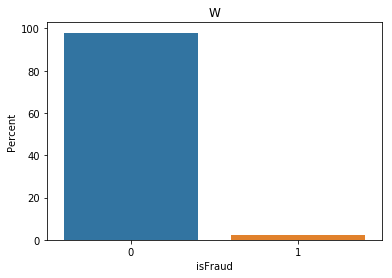

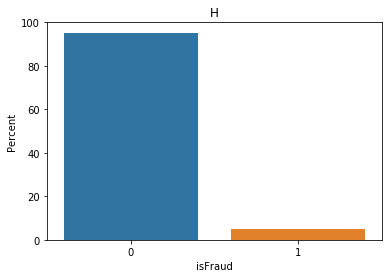

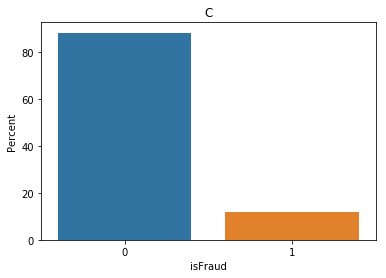

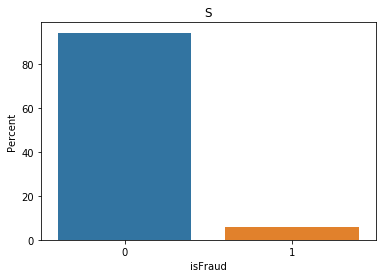

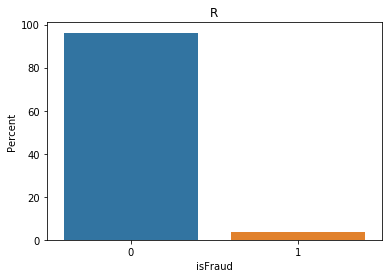

In [27]:
prodTypes = train_transaction_data['ProductCD'].unique()
for i,i_prod in enumerate(prodTypes):
    productData = eval('train_transaction_data.loc[train_transaction_data["ProductCD"]=="'+i_prod+'"]')
    plt.figure(i)
    ax = sns.barplot(x="isFraud", y="isFraud", data=productData, estimator=lambda x: len(x) / len(productData) * 100)
    ax.set(ylabel="Percent")
    ax.set_title(i_prod)

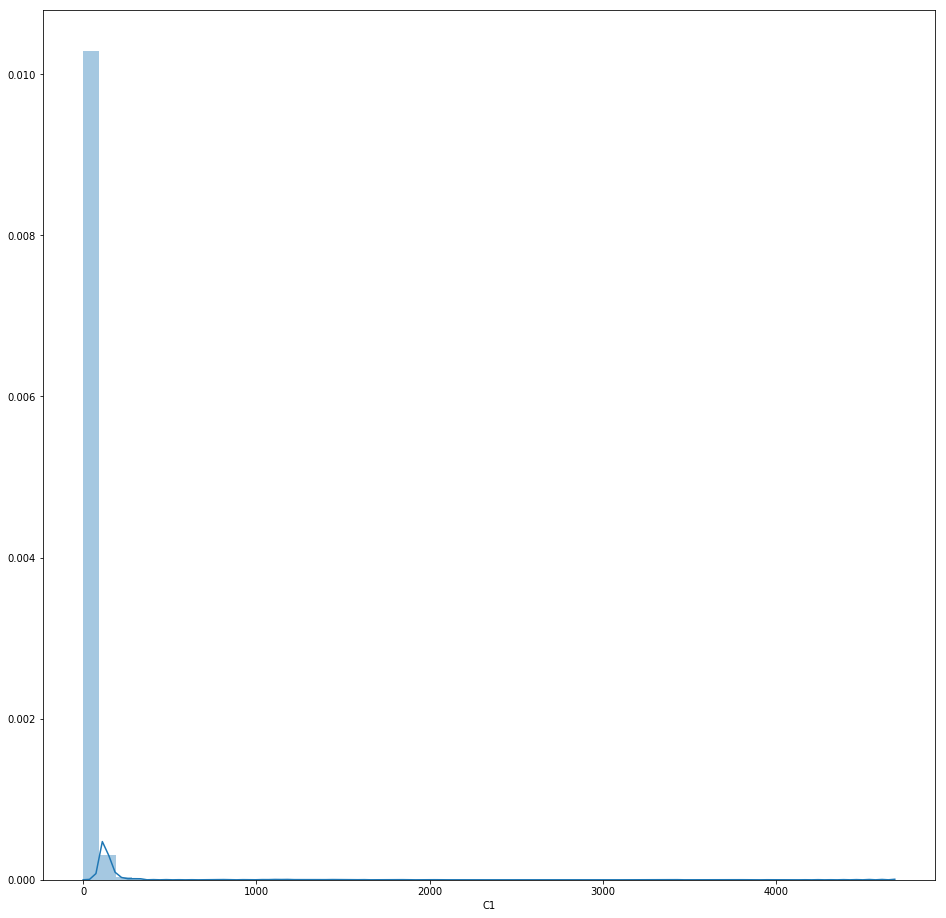

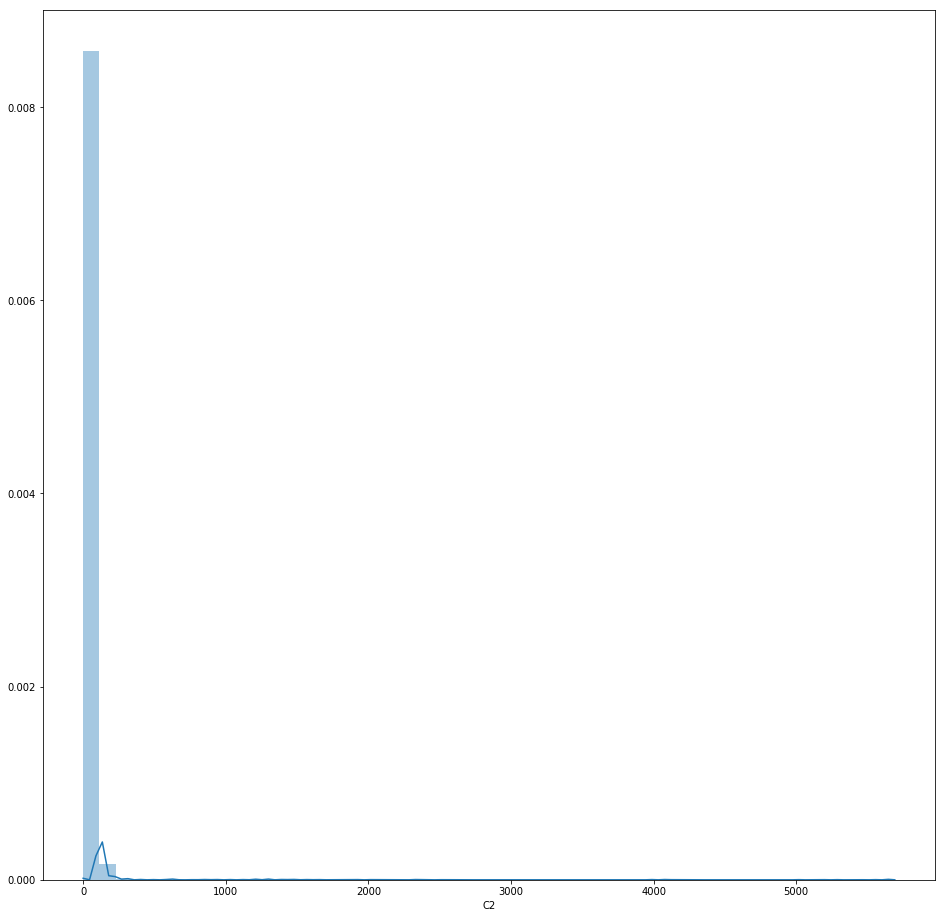

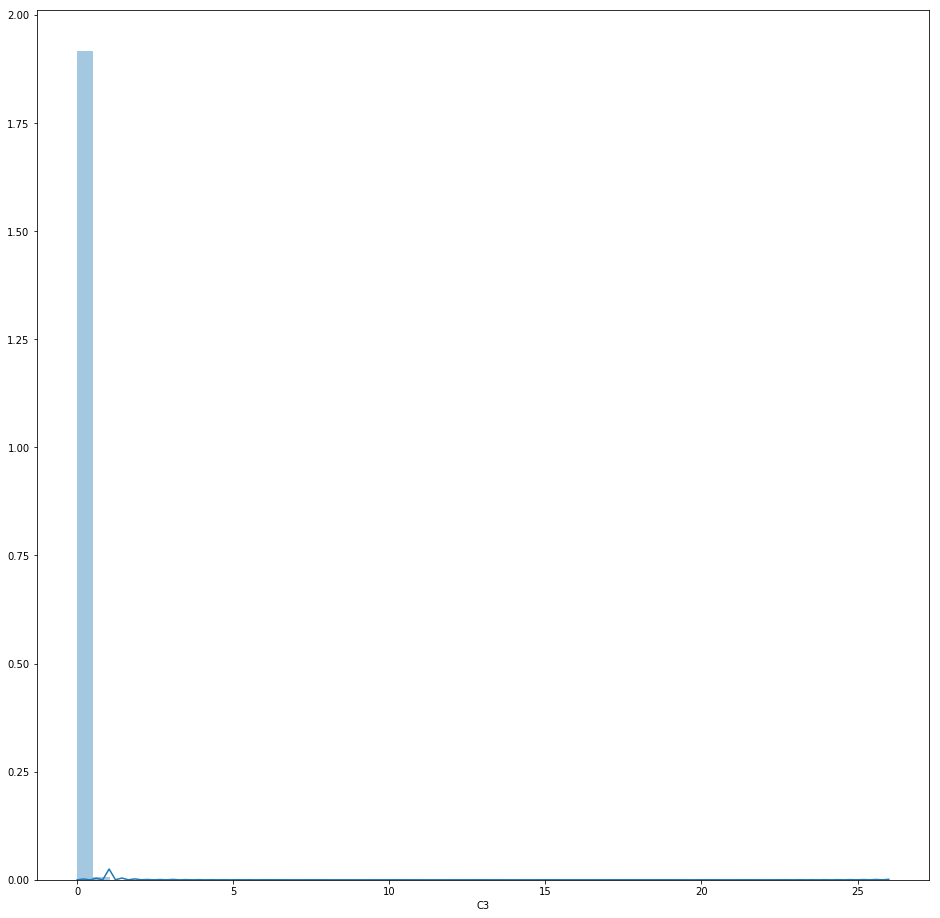

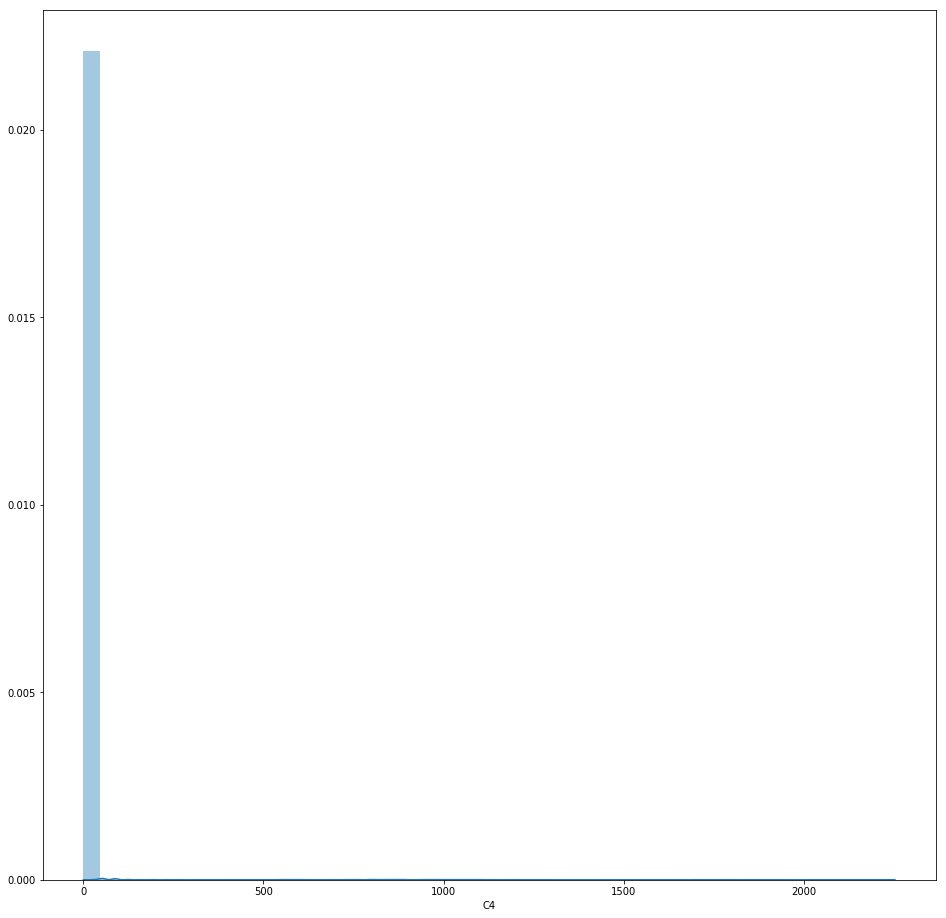

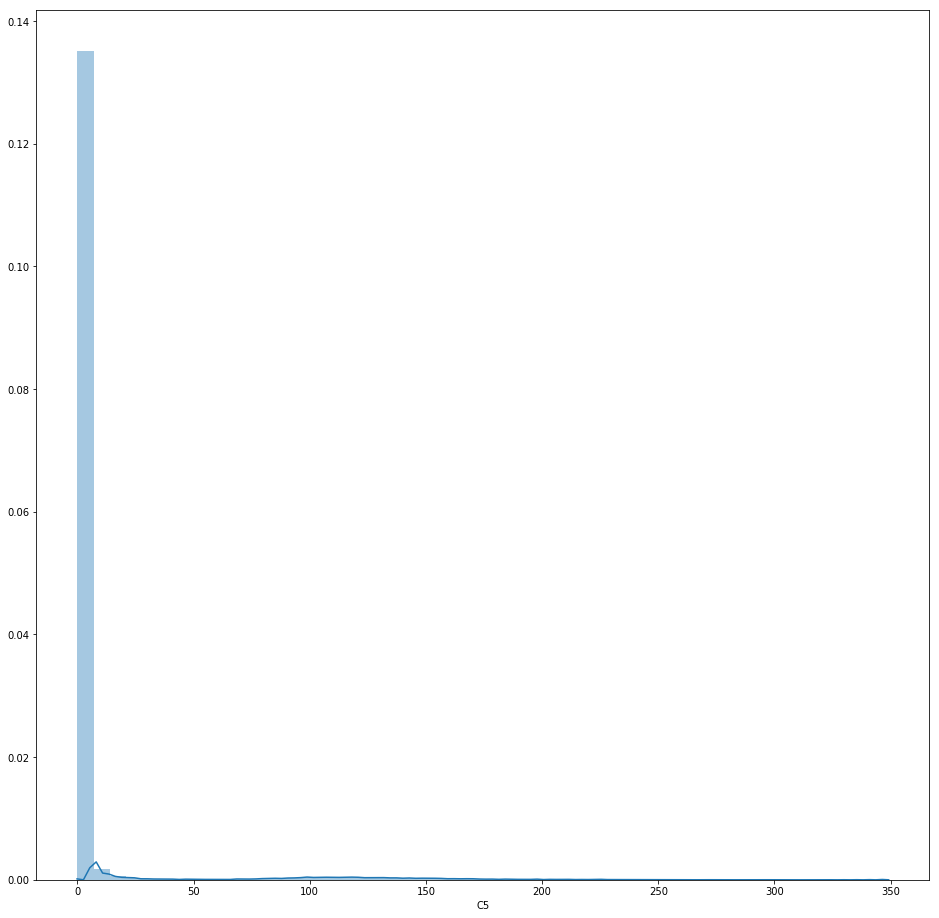

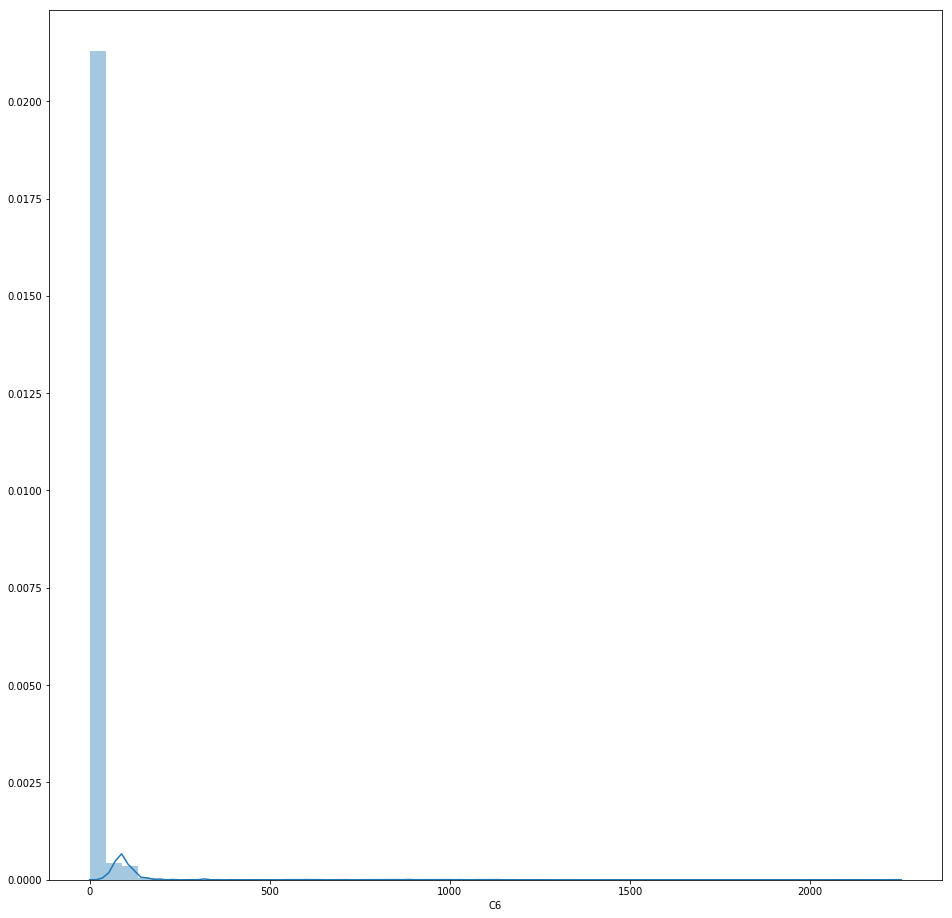

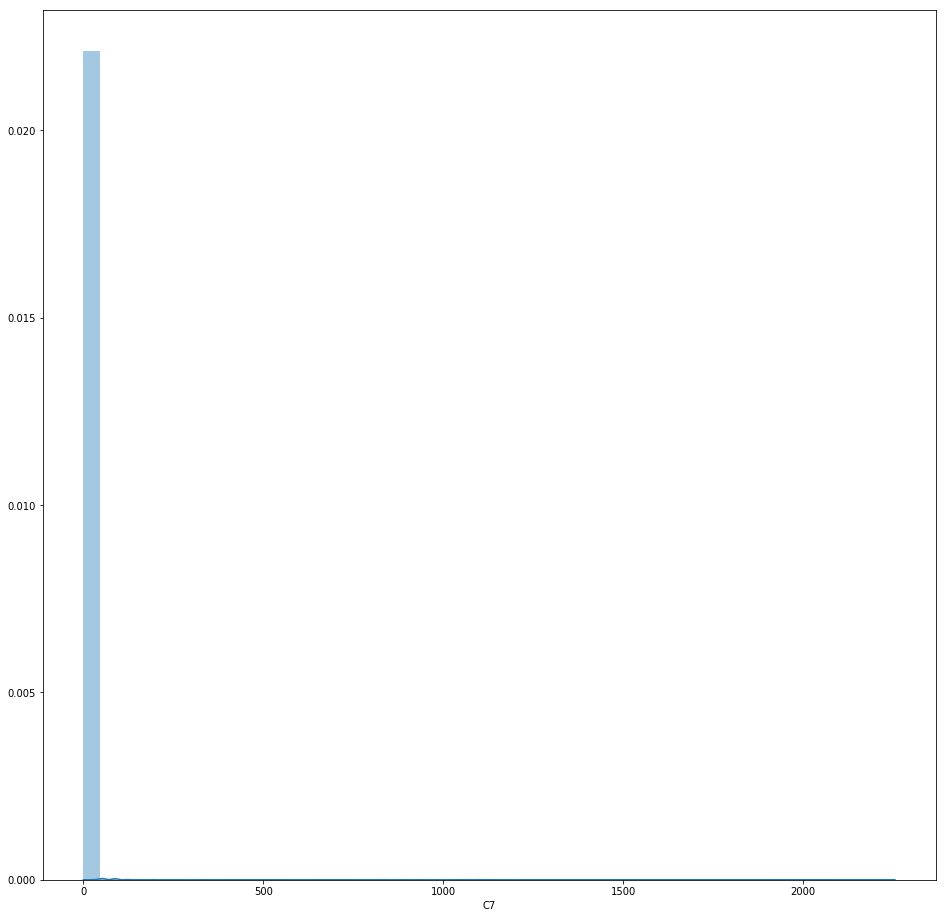

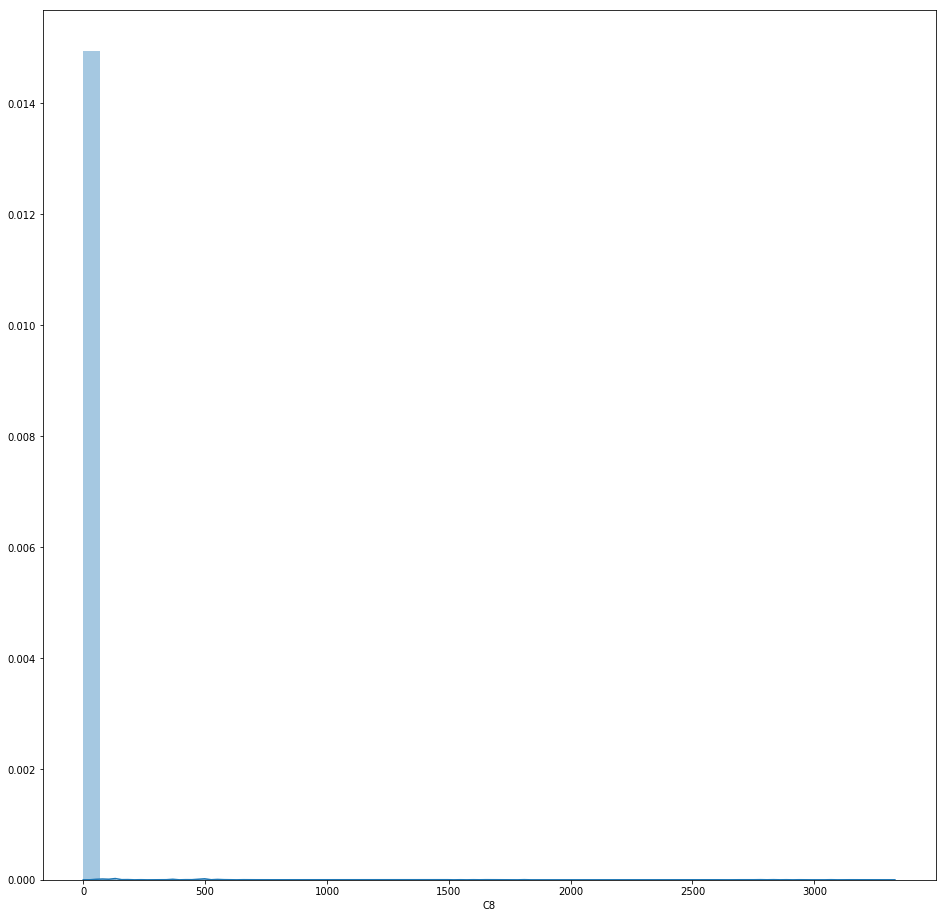

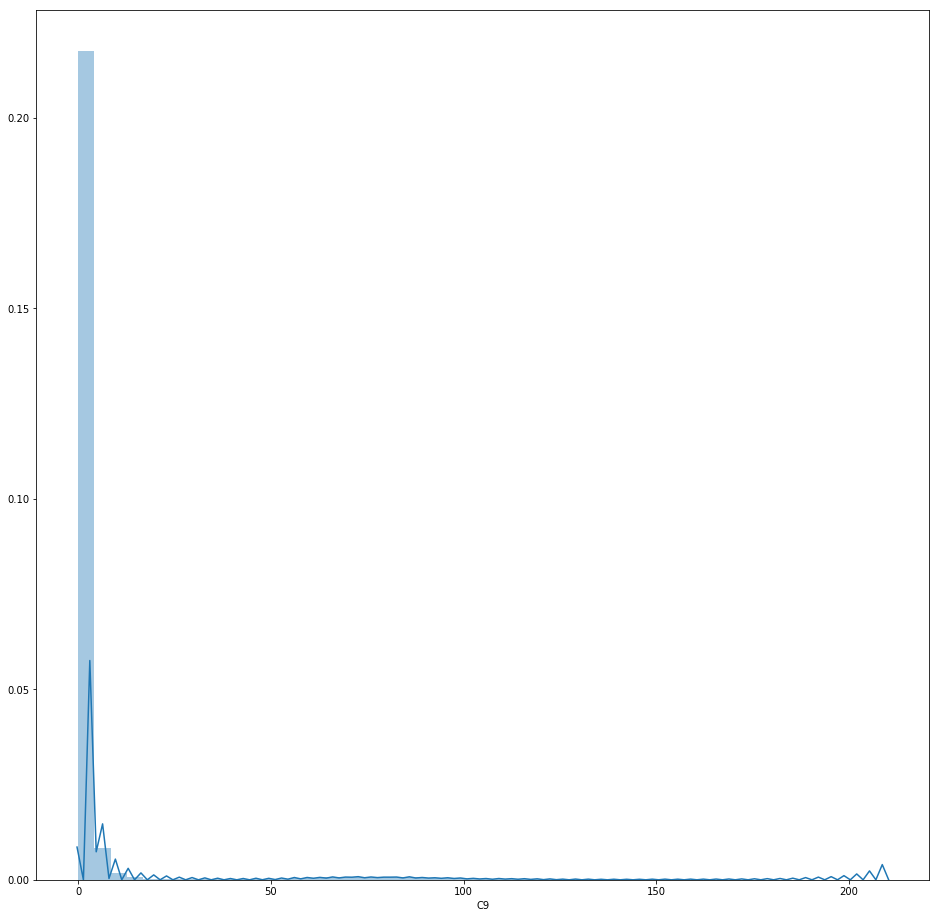

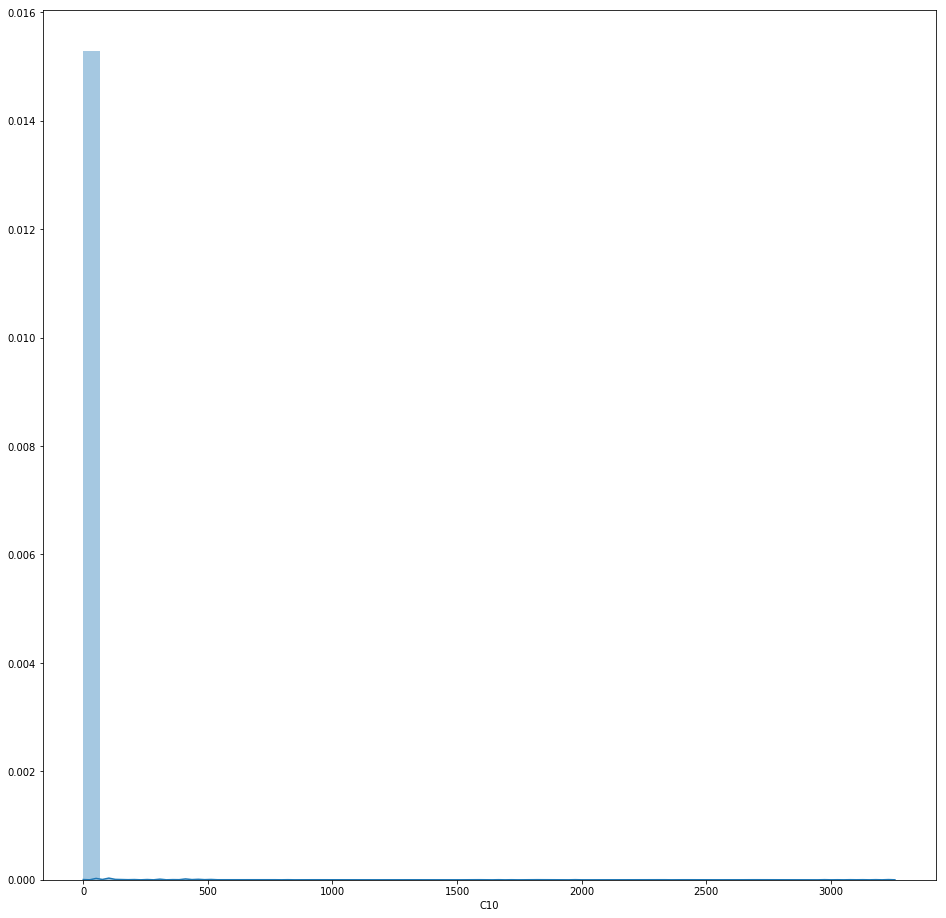

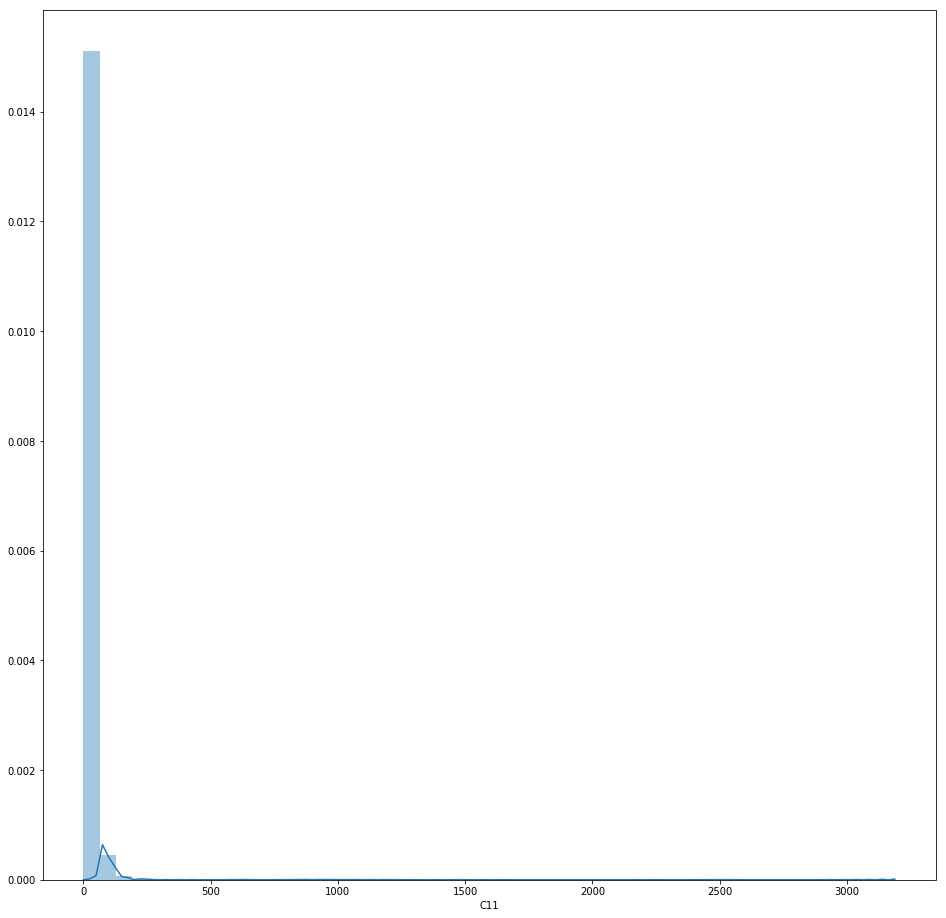

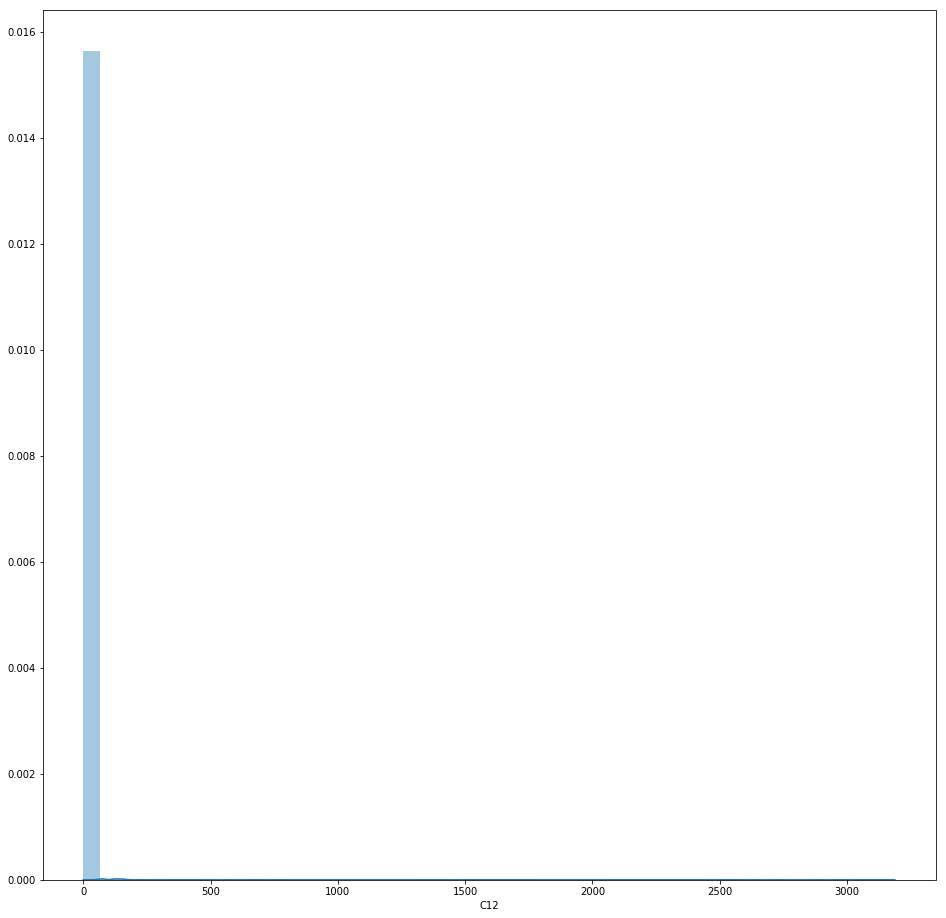

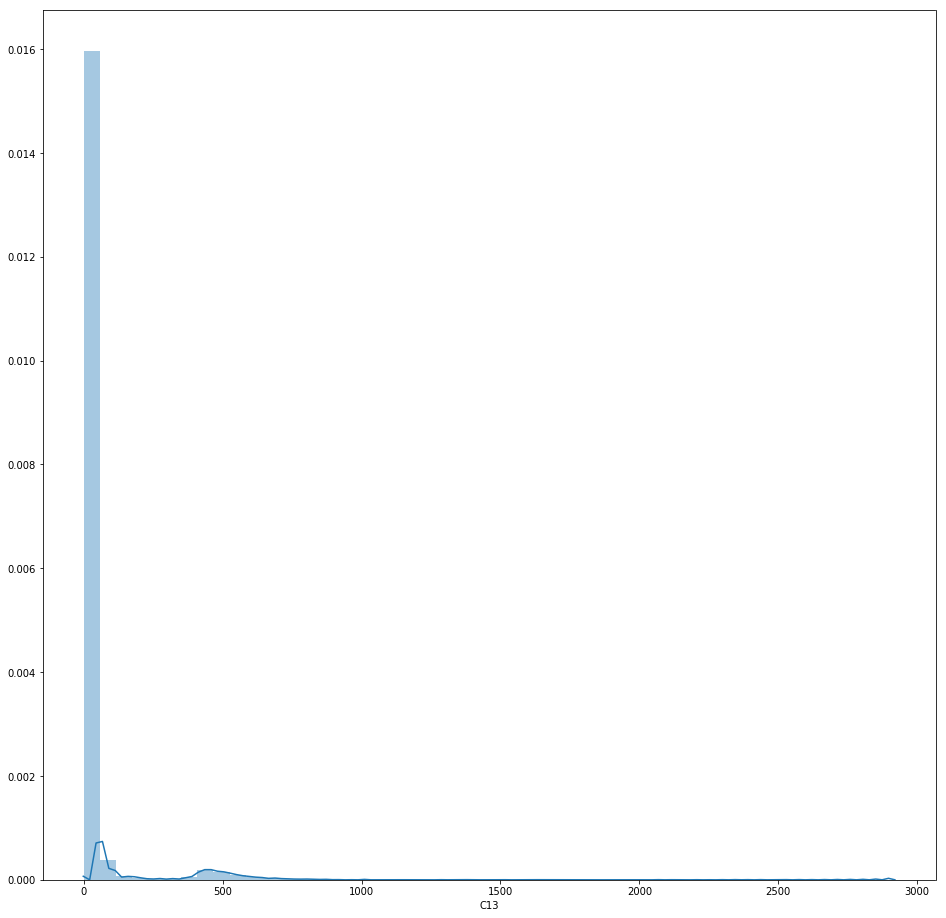

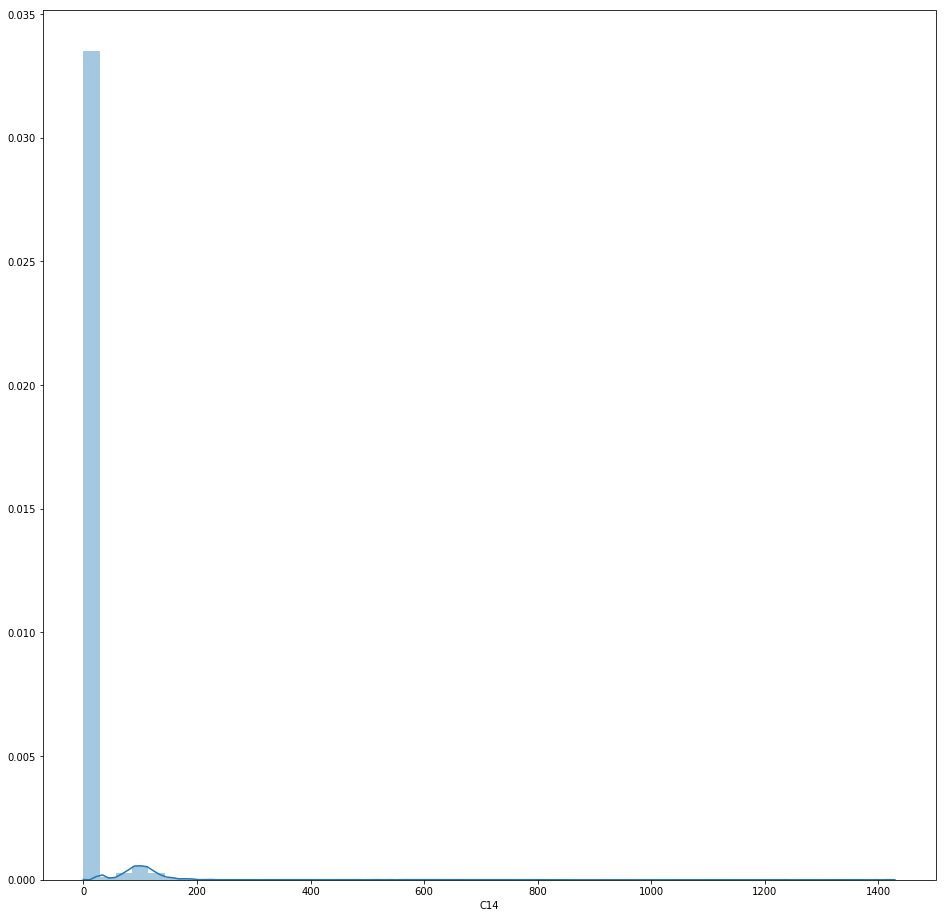

In [28]:
for i in range(1,15):    
    plt.figure(figsize=(16, 16))
    sns.distplot(eval('train_transaction_data["C'+str(i)+'"]'))
    ax.set(ylabel="Distribution")
    ax.set_title(['C'+str(i)])    

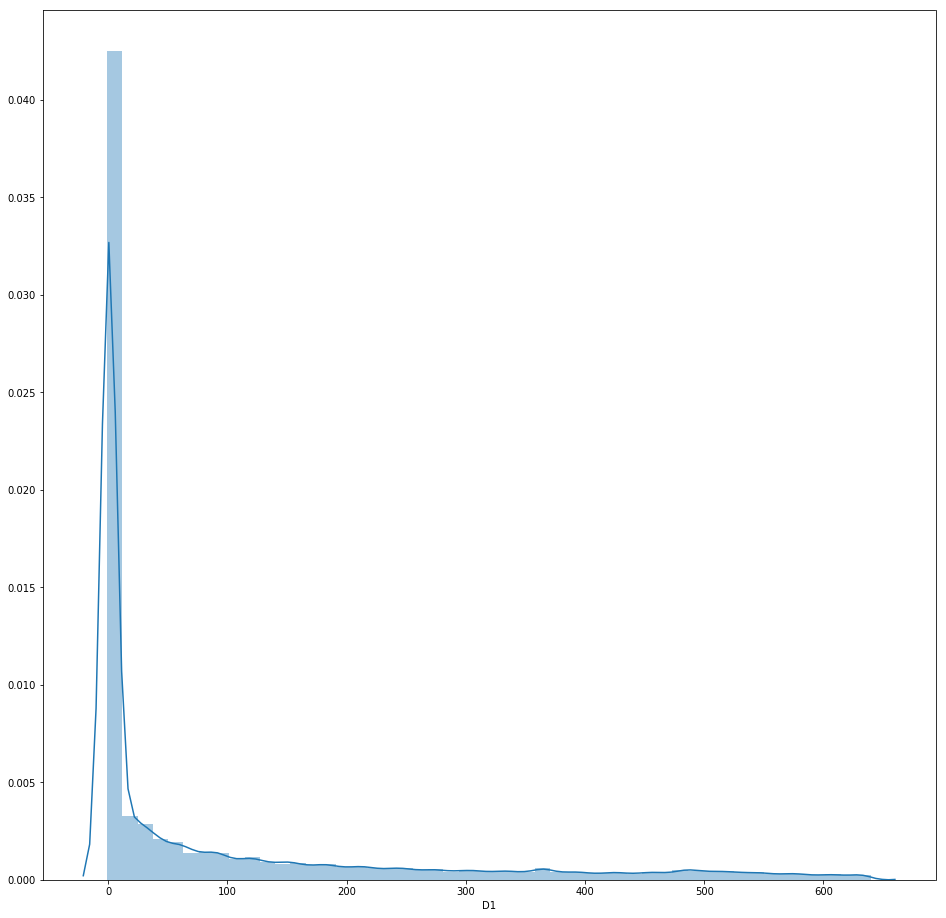

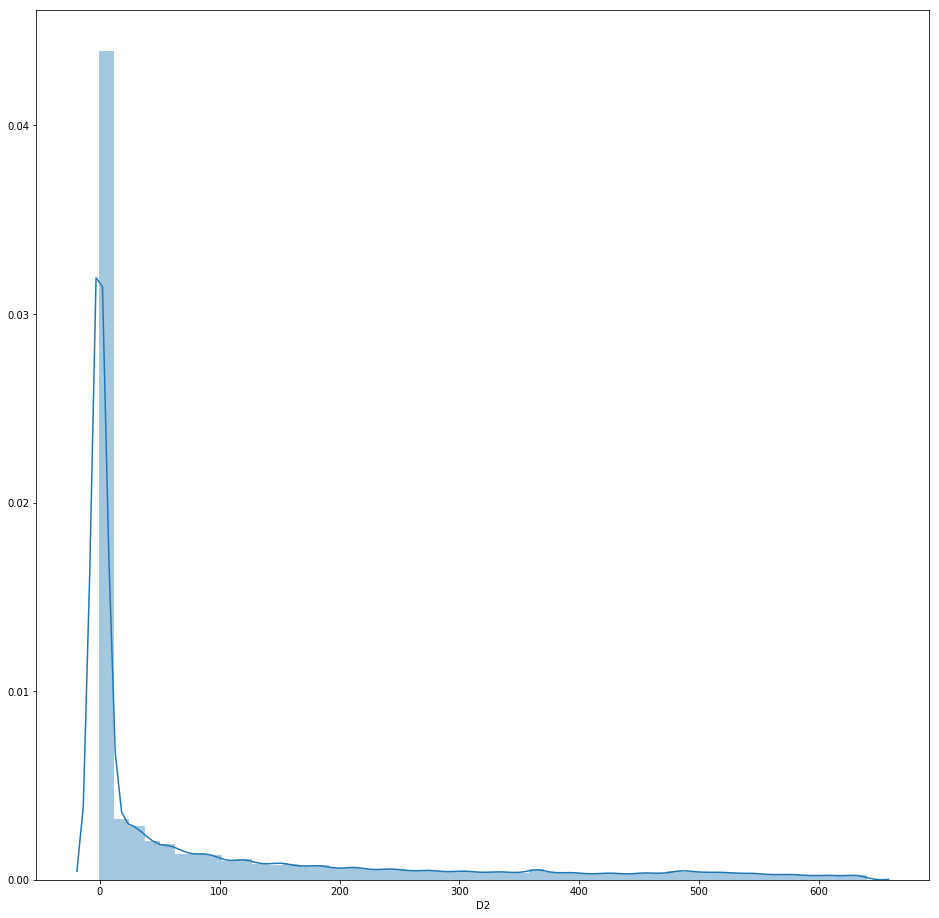

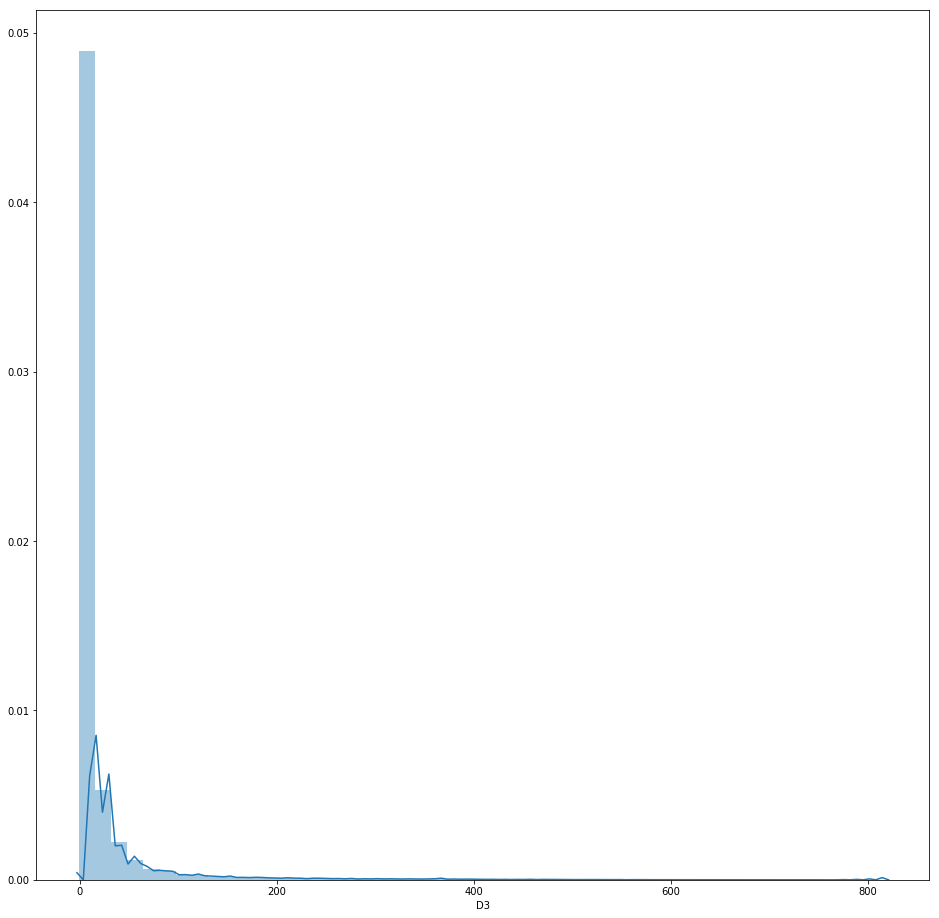

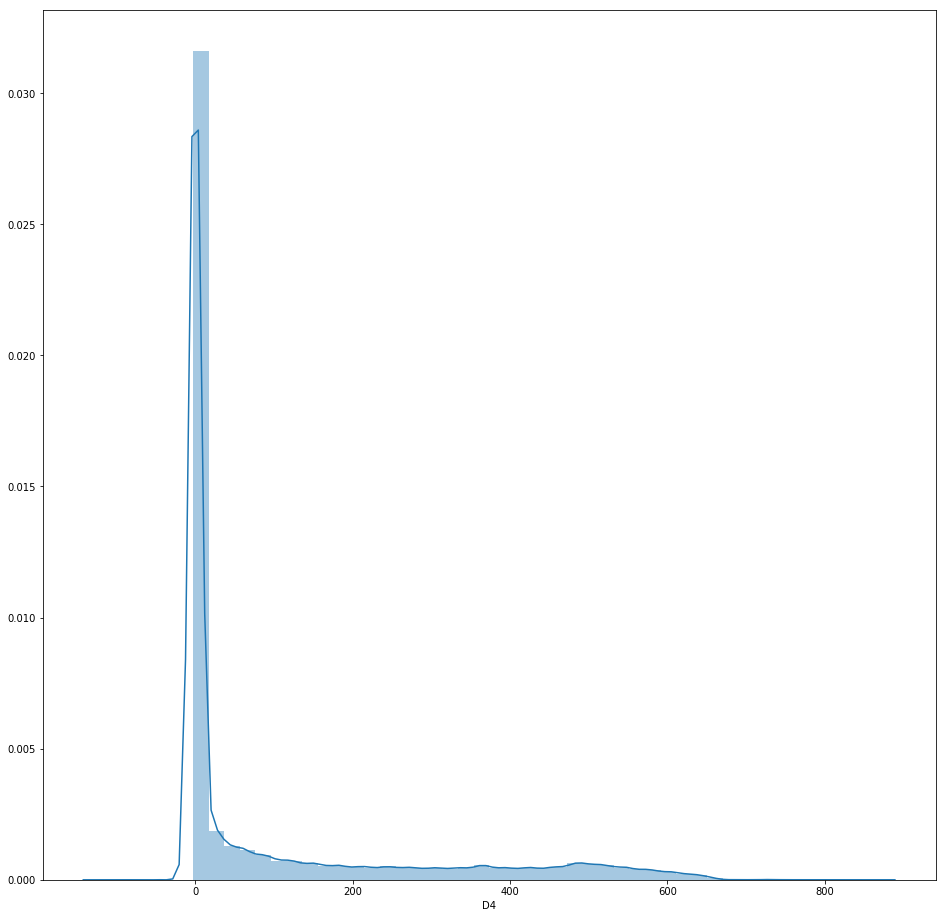

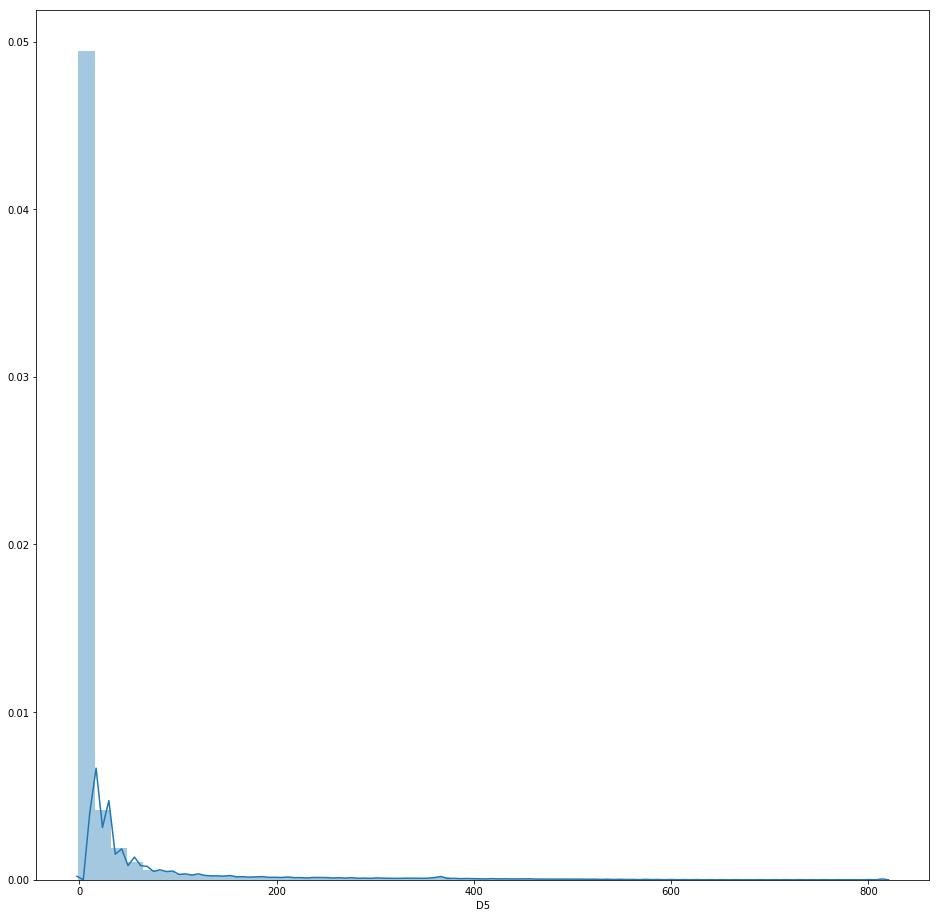

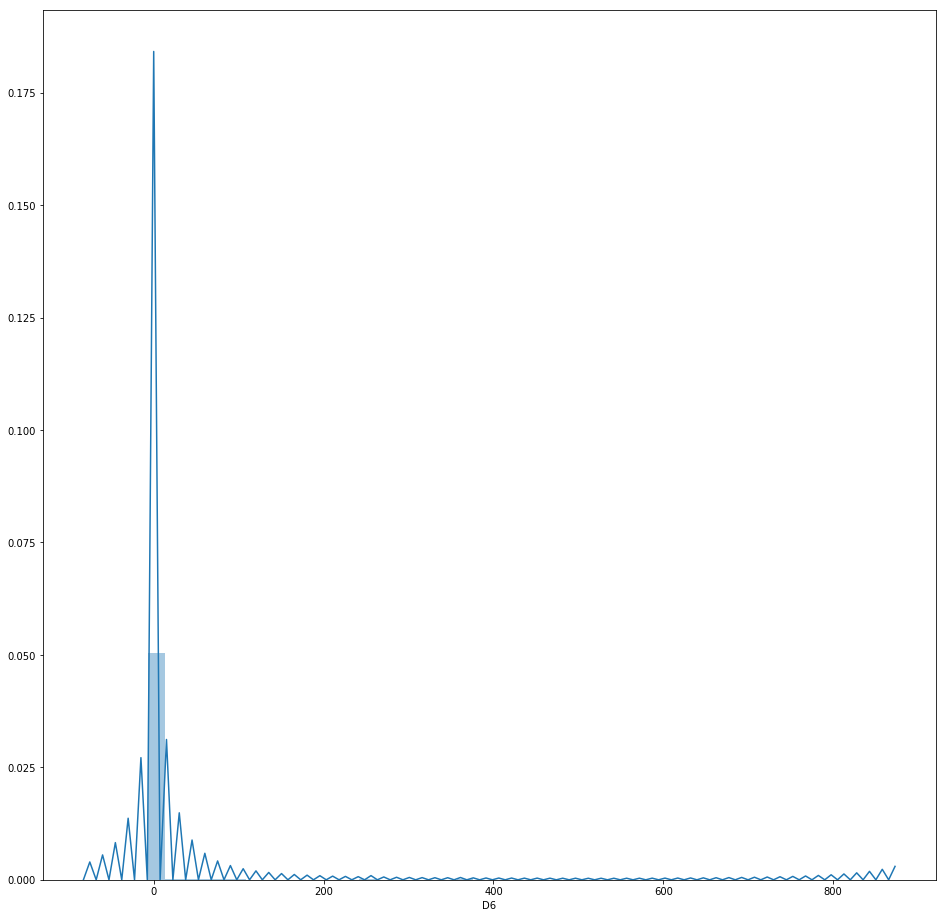

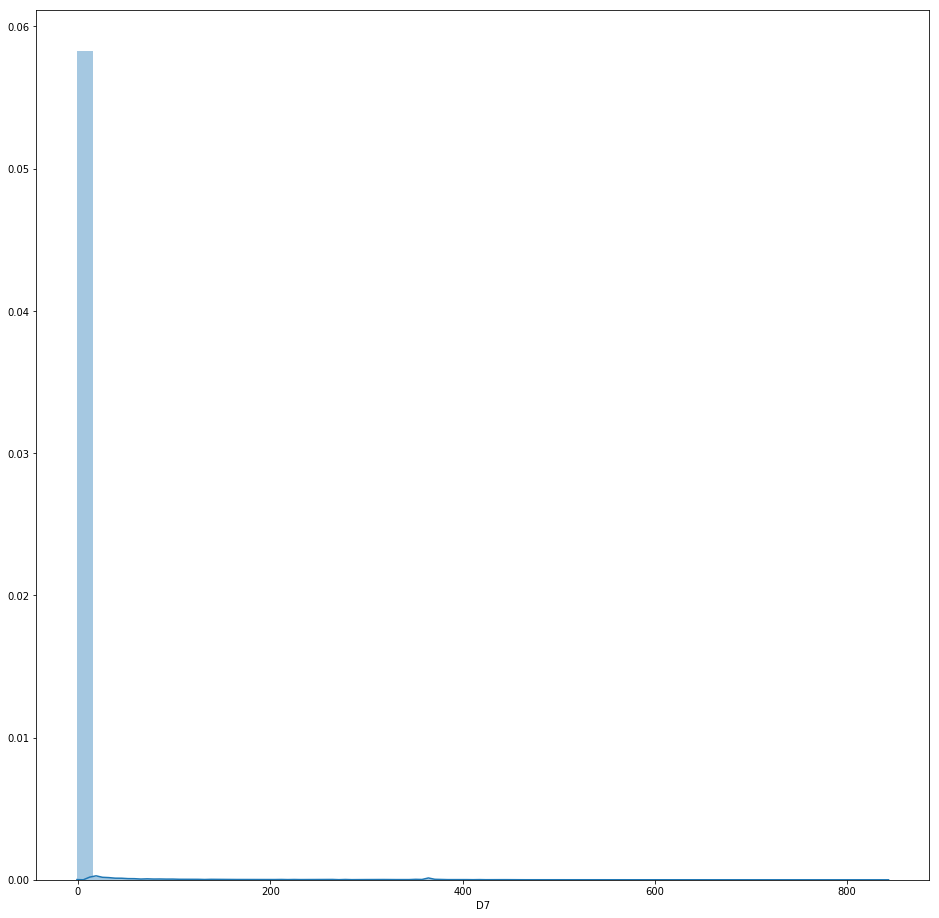

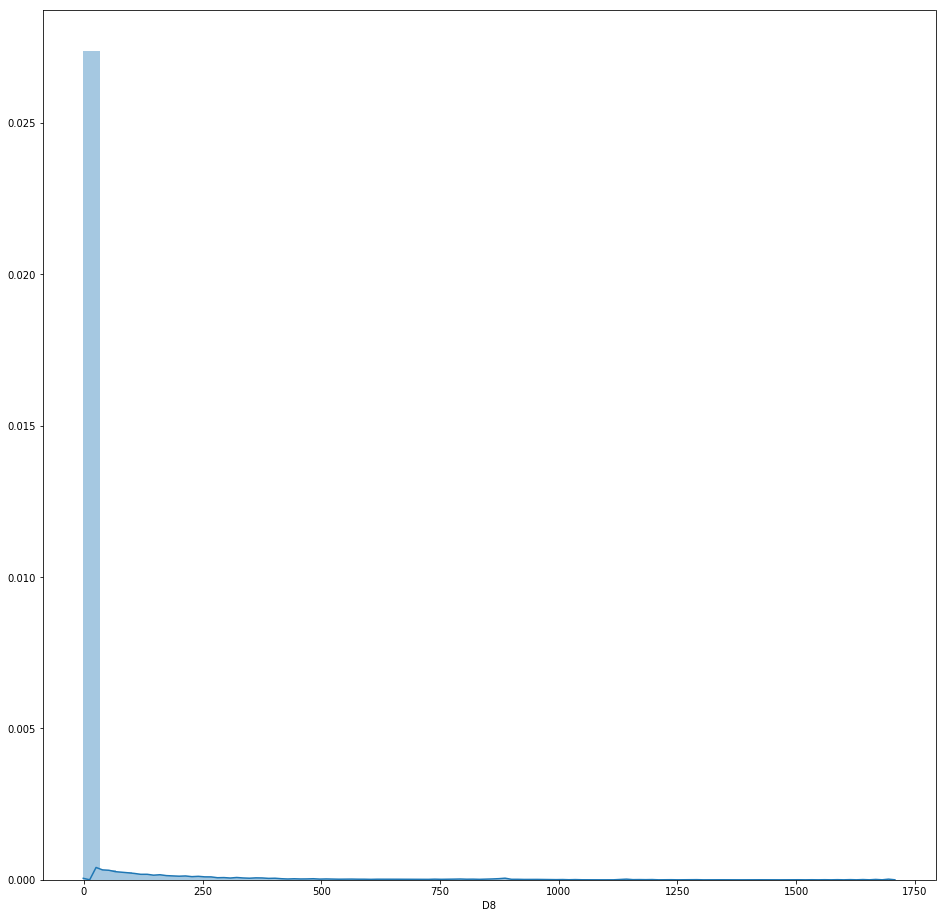

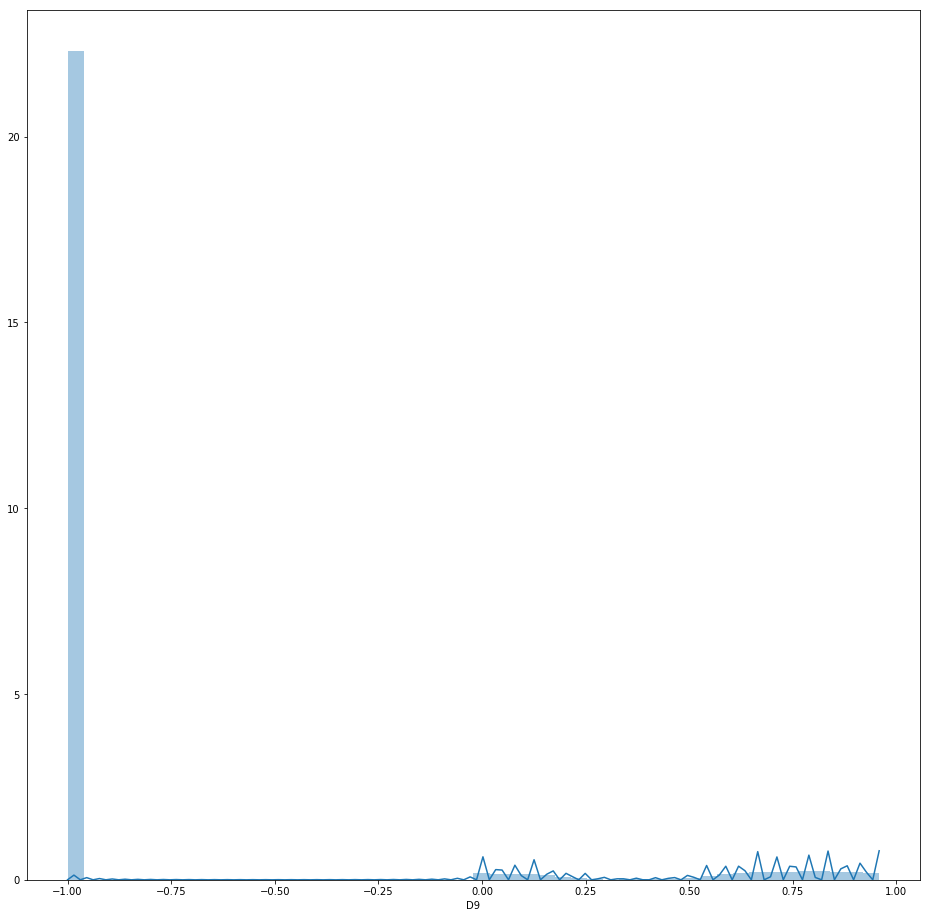

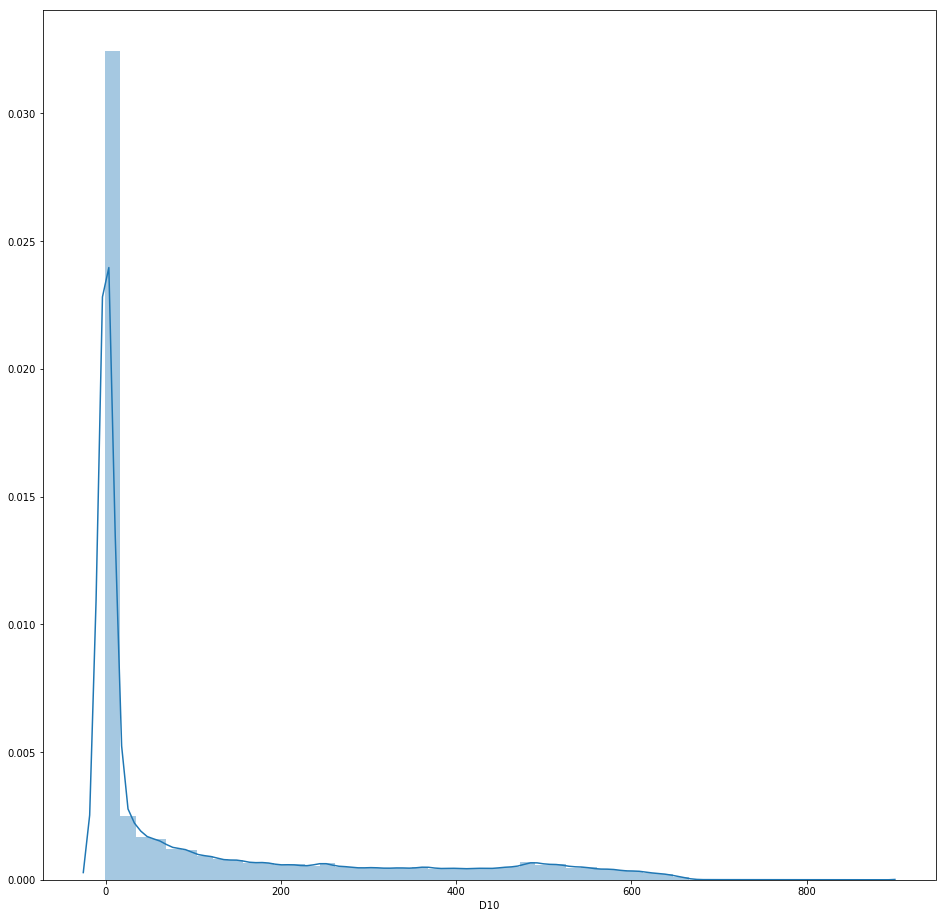

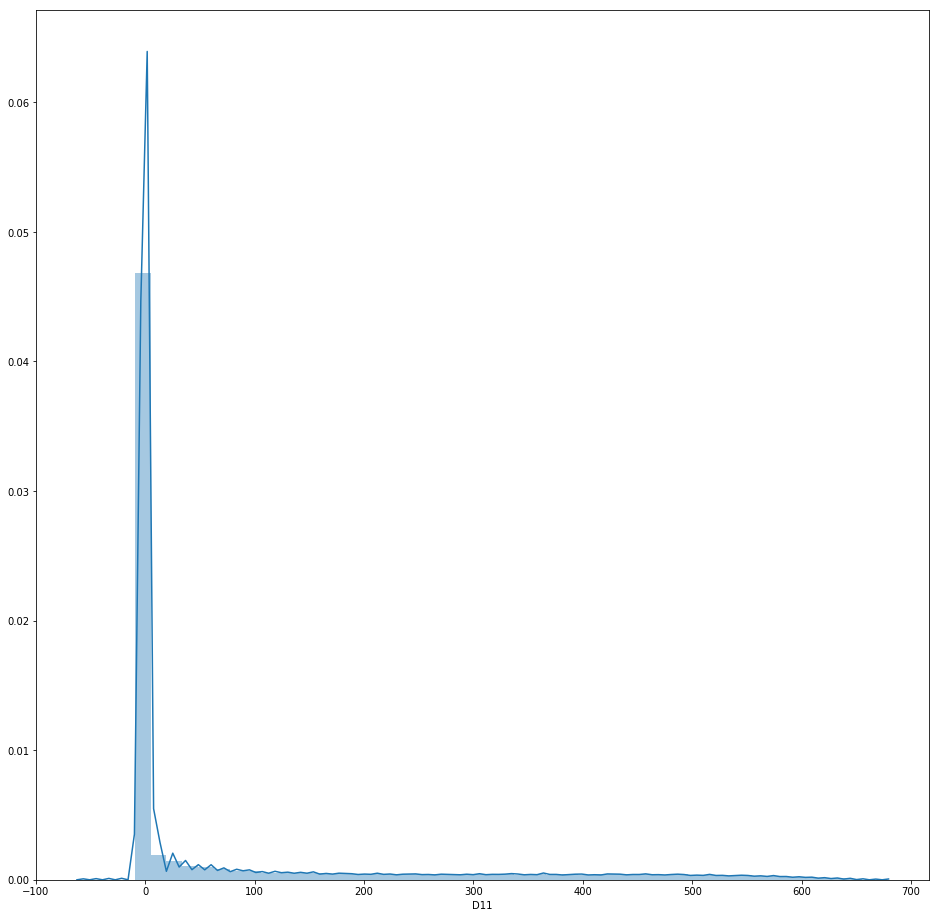

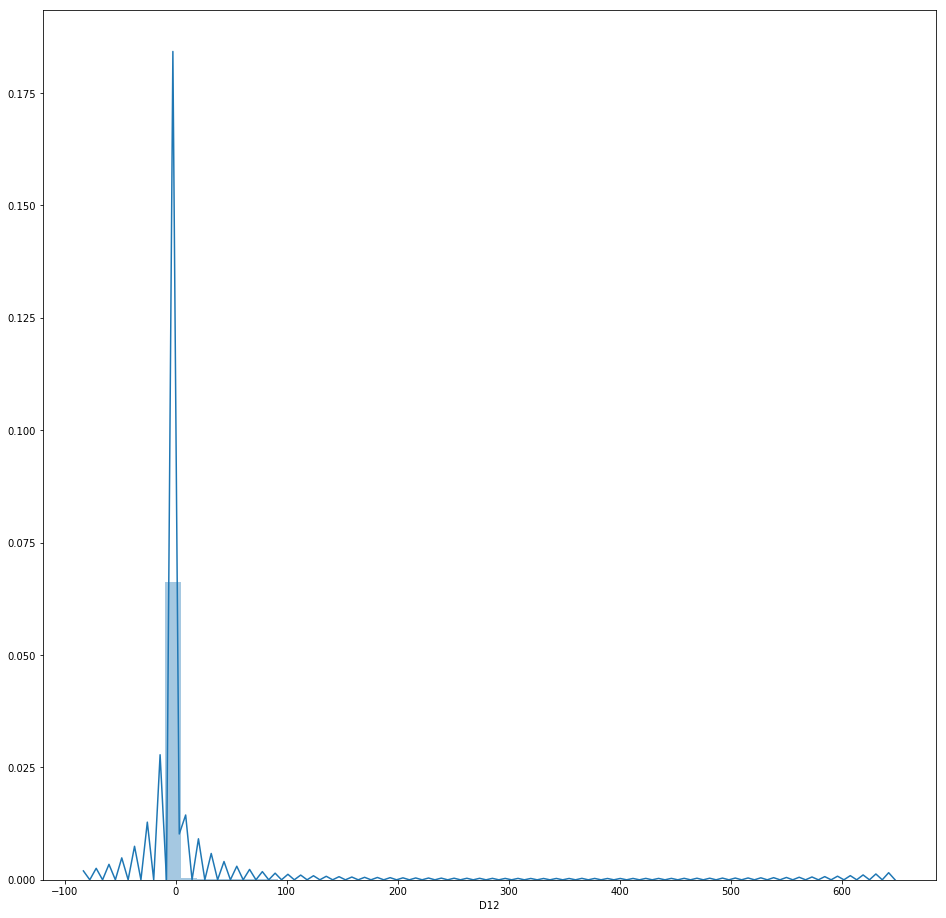

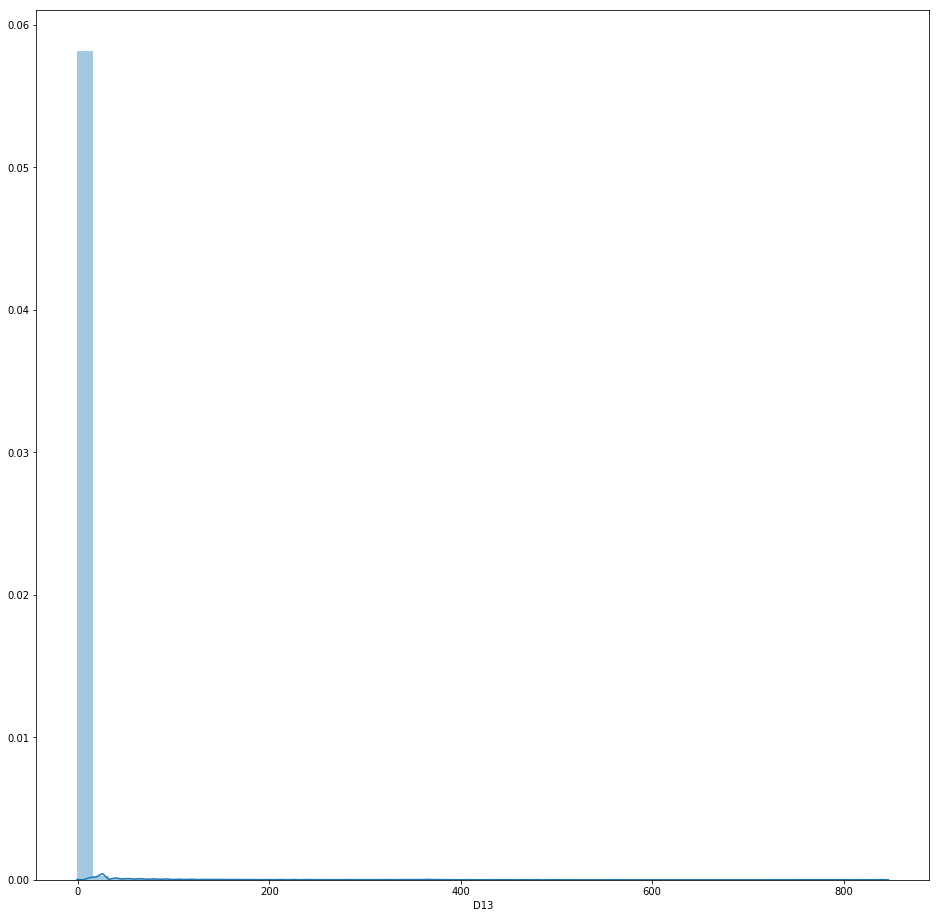

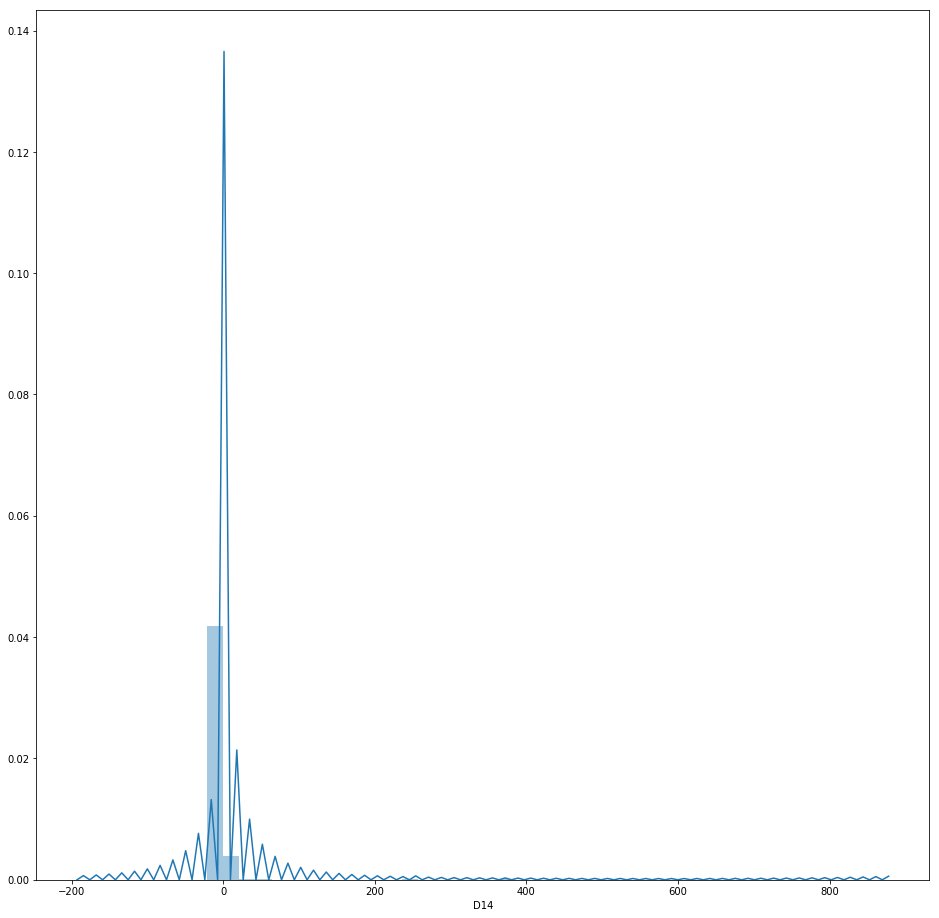

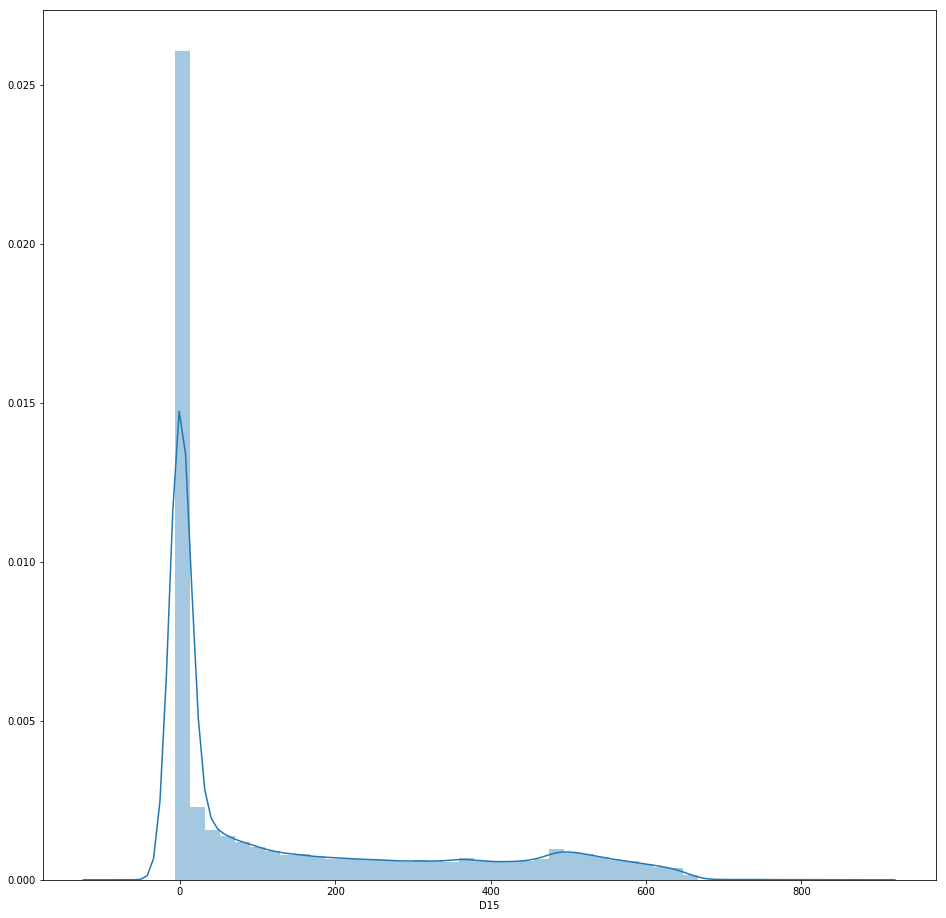

In [29]:
for i in range(1,16):    
    plt.figure(figsize=(16, 16))
    sns.distplot(eval('train_transaction_data["D'+str(i)+'"]'))
    ax.set(ylabel="Distribution")
    ax.set_title(['D'+str(i)])    

In [30]:
del fraudDataTransaction,normalDataTransaction,productData,cardData

In [31]:
np.unique(train_identity_data['id_30'])

array(['Android', 'Android 4.4.2', 'Android 5.0', 'Android 5.0.2',
       'Android 5.1.1', 'Android 6.0', 'Android 6.0.1', 'Android 7.0',
       'Android 7.1.1', 'Android 7.1.2', 'Android 8.0.0', 'Android 8.1.0',
       'Linux', 'Mac', 'Mac OS X 10.10', 'Mac OS X 10.11',
       'Mac OS X 10.12', 'Mac OS X 10.13', 'Mac OS X 10.6',
       'Mac OS X 10.9', 'Mac OS X 10_10_5', 'Mac OS X 10_11_3',
       'Mac OS X 10_11_4', 'Mac OS X 10_11_5', 'Mac OS X 10_11_6',
       'Mac OS X 10_12', 'Mac OS X 10_12_1', 'Mac OS X 10_12_2',
       'Mac OS X 10_12_3', 'Mac OS X 10_12_4', 'Mac OS X 10_12_5',
       'Mac OS X 10_12_6', 'Mac OS X 10_13_1', 'Mac OS X 10_13_2',
       'Mac OS X 10_13_3', 'Mac OS X 10_13_4', 'Mac OS X 10_13_5',
       'Mac OS X 10_6_8', 'Mac OS X 10_7_5', 'Mac OS X 10_8_5',
       'Mac OS X 10_9_5', 'Windows', 'Windows 10', 'Windows 7',
       'Windows 8', 'Windows 8.1', 'Windows Vista', 'Windows XP', 'func',
       'iOS', 'iOS 10.0.2', 'iOS 10.1.1', 'iOS 10.2.0', 'iOS 10.2.1',

In [32]:
#collapse os types - id_30
train_identity_data.loc[train_identity_data['id_30'].str.contains('Mac', na=False), 'id_30'] = 'mac'
train_identity_data.loc[train_identity_data['id_30'].str.contains('iOS', na=False), 'id_30'] = 'iOS'
train_identity_data.loc[train_identity_data['id_30'].str.contains('Android', na=False), 'id_30'] = 'android'
train_identity_data.loc[train_identity_data['id_30'].str.contains('Windows', na=False), 'id_30'] = 'Windows'
train_identity_data.loc[train_identity_data['id_30'].str.contains('Linux', na=False), 'id_30'] = 'Linux'

In [33]:
train_identity_data['device_name'] = train_identity_data['DeviceInfo'].str.split('/', expand=True)[0]

train_identity_data.loc[train_identity_data['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung'
train_identity_data.loc[train_identity_data['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
train_identity_data.loc[train_identity_data['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung'
train_identity_data.loc[train_identity_data['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
train_identity_data.loc[train_identity_data['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola'
train_identity_data.loc[train_identity_data['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola'
train_identity_data.loc[train_identity_data['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG'
train_identity_data.loc[train_identity_data['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV'
train_identity_data.loc[train_identity_data['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
train_identity_data.loc[train_identity_data['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
train_identity_data.loc[train_identity_data['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei'
train_identity_data.loc[train_identity_data['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE'
train_identity_data.loc[train_identity_data['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE'
train_identity_data.loc[train_identity_data['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux'
train_identity_data.loc[train_identity_data['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony'
train_identity_data.loc[train_identity_data['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC'
train_identity_data.loc[train_identity_data['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'

train_identity_data.loc[train_identity_data.device_name.isin(train_identity_data.device_name.value_counts()[train_identity_data.device_name.value_counts() < 200].index), 'device_name'] = "Others"

In [34]:
np.unique(train_identity_data['id_30'])

array(['Linux', 'Windows', 'android', 'func', 'iOS', 'mac', 'missing',
       'other'], dtype=object)

In [35]:
print(np.unique(train_identity_data['id_31']))
train_identity_data['id_31'] = train_identity_data['id_31'].str.replace('\d+', '')
print(np.unique(train_identity_data['id_31']))

['BLU/Dash' 'Cherry' 'Generic/Android' 'Generic/Android 7.0' 'Inco/Minion'
 'LG/K-200' 'Lanix/Ilium' 'M4Tel/M4' 'Microsoft/Windows' 'Mozilla/Firefox'
 'Nokia/Lumia' 'Samsung/SCH' 'Samsung/SM-G531H' 'Samsung/SM-G532M'
 'ZTE/Blade' 'android' 'android browser 4.0' 'android webview 4.0' 'aol'
 'chrome' 'chrome 43.0 for android' 'chrome 46.0 for android'
 'chrome 49.0' 'chrome 49.0 for android' 'chrome 50.0 for android'
 'chrome 51.0' 'chrome 51.0 for android' 'chrome 52.0 for android'
 'chrome 53.0 for android' 'chrome 54.0 for android' 'chrome 55.0'
 'chrome 55.0 for android' 'chrome 56.0' 'chrome 56.0 for android'
 'chrome 57.0' 'chrome 57.0 for android' 'chrome 58.0'
 'chrome 58.0 for android' 'chrome 59.0' 'chrome 59.0 for android'
 'chrome 60.0' 'chrome 60.0 for android' 'chrome 61.0'
 'chrome 61.0 for android' 'chrome 62.0' 'chrome 62.0 for android'
 'chrome 62.0 for ios' 'chrome 63.0' 'chrome 63.0 for android'
 'chrome 63.0 for ios' 'chrome 64.0' 'chrome 64.0 for android'
 'chrome 6

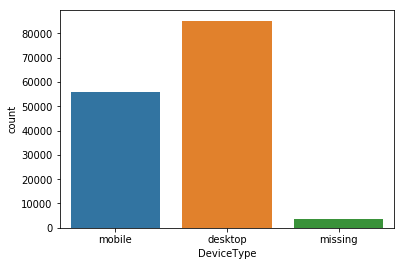

In [36]:
sns.countplot(train_identity_data['DeviceType'])

In [37]:
raw_train_data = pd.merge(train_transaction_data, train_identity_data, on='TransactionID', how='left')
del train_transaction_data,train_identity_data

In [38]:
raw_train_data_columns = raw_train_data.columns
numericCols = raw_train_data._get_numeric_data().columns
categoricalCols = list(set(raw_train_data_columns) - set(numericCols))
print('The categorical columns in training data are: ',categoricalCols)
raw_train_data[categoricalCols] = raw_train_data[categoricalCols].replace({ np.nan:'missing'})
raw_train_data[numericCols] = raw_train_data[numericCols].replace({ np.nan:-1})

The categorical columns in training data are:  ['M1', 'M2', 'id_29', 'P_emaildomain', 'id_33', 'id_35', 'device_name', 'id_27', 'id_30', 'ProductCD', 'id_37', 'M6', 'card4', 'id_34', 'id_12', 'id_38', 'M9', 'id_15', 'id_16', 'M3', 'DeviceType', 'id_23', 'id_36', 'R_emaildomain', 'id_28', 'M8', 'M7', 'DeviceInfo', 'card6', 'id_31', 'M4', 'M5']


In [39]:
raw_train_data = reduce_memory_usage(raw_train_data, deep=True, verbose=True)
print(raw_train_data.head(10))

Column 'TransactionID' converted from int64 to int32
Column 'isFraud' converted from int64 to int8
Column 'TransactionDT' converted from int64 to int32
Column 'TransactionAmt' converted from float64 to float32
Column 'card1' converted from int64 to int16
Column 'card2' converted from float64 to float32
Column 'card3' converted from float64 to float32
Column 'card5' converted from float64 to float32
Column 'addr1' converted from float64 to float32
Column 'addr2' converted from float64 to float32
Column 'dist1' converted from float64 to float32
Column 'dist2' converted from float64 to float32
Column 'C1' converted from float64 to float32
Column 'C2' converted from float64 to float32
Column 'C3' converted from float64 to float32
Column 'C4' converted from float64 to float32
Column 'C5' converted from float64 to float32
Column 'C6' converted from float64 to float32
Column 'C7' converted from float64 to float32
Column 'C8' converted from float64 to float32
Column 'C9' converted from float64

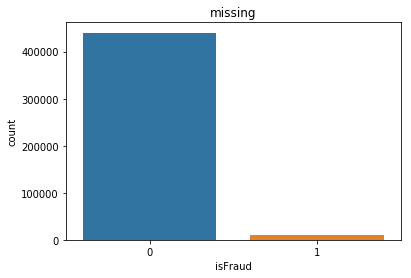

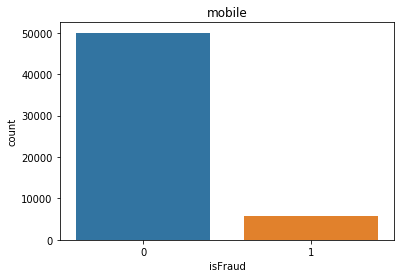

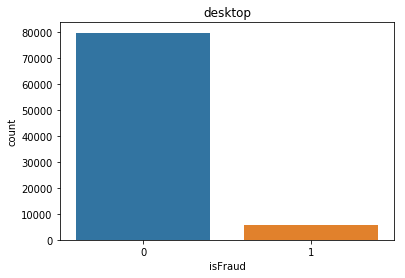

In [40]:
deviceTypes = raw_train_data['DeviceType'].unique()
for i,i_device in enumerate(deviceTypes):
    deviceData = eval('raw_train_data.loc[raw_train_data["DeviceType"]=="'+i_device+'"]')
    plt.figure(i)
    sns.countplot(deviceData['isFraud']).set_title(i_device)

looks like merging the two data tables has created a lot of missing values. let us first try to identify good features from these.

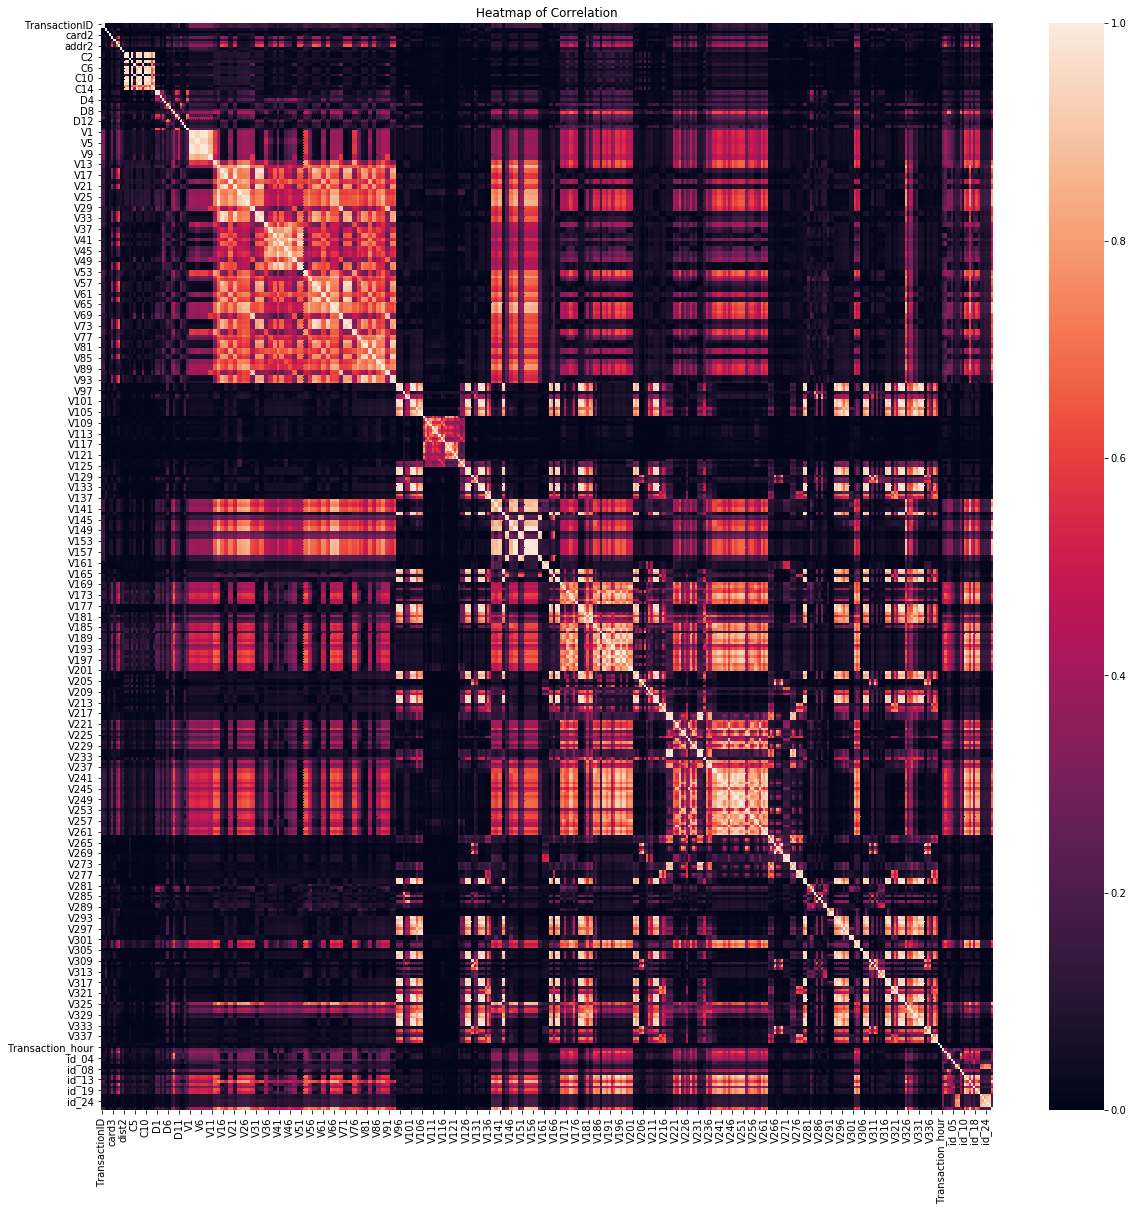

In [41]:
variables = list(numericCols)
variables.remove('isFraud')
correlationMatrix = raw_train_data.loc[:, variables].corr().abs()
plt.figure(figsize=(20,20))
heat = sns.heatmap(data=correlationMatrix)
plt.title('Heatmap of Correlation')
na_vals = np.sum(raw_train_data.loc[:,variables]==-1)/raw_train_data.shape[0]
goodNumericVars = []
for i_var in variables:    
    if na_vals[i_var] < 1:        
        goodNumericVars.append(i_var)
goodNumericVars.remove('TransactionDT')
goodNumericVars.remove('TransactionID')
corrThresh = 1
# Select upper triangle of correlation matrix
upper = correlationMatrix.where(np.triu(np.ones(correlationMatrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > corrThresh)]

In [42]:
for i_var in to_drop:
    if i_var in goodNumericVars:
        goodNumericVars.remove(i_var)

Now that we have identified good numeric variables, let us use just the missing data as benchmark for the categorical variables

In [43]:
del to_drop,corrThresh,upper,correlationMatrix,na_vals

In [44]:
variables = list(categoricalCols)
na_vals = np.sum(raw_train_data.loc[:,variables]=='missing')/raw_train_data.shape[0]
goodCategoricalVars = []
for i_var in variables:    
    if na_vals[i_var] < 1:        
        goodCategoricalVars.append(i_var)

In [45]:
featuresToUse = goodNumericVars+goodCategoricalVars
train_data = raw_train_data.loc[:,featuresToUse]
target_data = raw_train_data['isFraud']

In [46]:
featuresToUse

['TransactionAmt',
 'card1',
 'card2',
 'card3',
 'card5',
 'addr1',
 'addr2',
 'dist1',
 'dist2',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V41',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V53',
 'V54',
 'V55',
 'V56',
 'V57',
 'V58',
 'V59',
 'V60',
 'V61',
 'V62',
 'V63',
 'V64',
 'V65',
 'V66',
 'V67',
 'V68',
 'V69',
 'V70',
 'V71',
 'V72',
 'V73',
 'V74',
 'V75',
 'V76',
 'V77',
 'V78',
 'V79',
 'V80',
 'V81',
 'V82',
 'V83',
 'V84',
 'V85',
 'V86',
 'V87',


In [47]:
#https://www.kaggle.com/artgor/eda-and-models#Feature-engineering
train_data['TransactionAmt_to_mean_card1'] = train_data['TransactionAmt'] / train_data.groupby(['card1'])['TransactionAmt'].transform('mean')
train_data['TransactionAmt_to_mean_card4'] = train_data['TransactionAmt'] / train_data.groupby(['card4'])['TransactionAmt'].transform('mean')
train_data['TransactionAmt_to_mean_card5'] = train_data['TransactionAmt'] / train_data.groupby(['card5'])['TransactionAmt'].transform('mean')
train_data['TransactionAmt_to_mean_addr1'] = train_data['TransactionAmt'] / train_data.groupby(['addr1'])['TransactionAmt'].transform('mean')
train_data['TransactionAmt_to_mean_id31'] = train_data['TransactionAmt'] / train_data.groupby(['id_31'])['TransactionAmt'].transform('mean')
train_data['TransactionAmt_to_mean_devicename'] = train_data['TransactionAmt'] / train_data.groupby(['device_name'])['TransactionAmt'].transform('mean')
train_data['TransactionAmt_to_mean_C1'] = train_data['TransactionAmt'] / train_data.groupby(['C1'])['TransactionAmt'].transform('mean')
train_data['TransactionAmt_to_mean_C3'] = train_data['TransactionAmt'] / train_data.groupby(['C3'])['TransactionAmt'].transform('mean')
train_data['TransactionAmt_to_mean_C5'] = train_data['TransactionAmt'] / train_data.groupby(['C5'])['TransactionAmt'].transform('mean')
train_data['TransactionAmt_to_mean_C13'] = train_data['TransactionAmt'] / train_data.groupby(['C13'])['TransactionAmt'].transform('mean')
train_data['TransactionAmt_to_std_card1'] = train_data['TransactionAmt'] / train_data.groupby(['card1'])['TransactionAmt'].transform('std')
train_data['TransactionAmt_to_std_card4'] = train_data['TransactionAmt'] / train_data.groupby(['card4'])['TransactionAmt'].transform('std')
train_data['TransactionAmt_to_std_card5'] = train_data['TransactionAmt'] / train_data.groupby(['card5'])['TransactionAmt'].transform('std')
train_data['TransactionAmt_to_std_addr1'] = train_data['TransactionAmt'] / train_data.groupby(['addr1'])['TransactionAmt'].transform('std')
train_data['TransactionAmt_to_std_id31'] = train_data['TransactionAmt'] / train_data.groupby(['id_31'])['TransactionAmt'].transform('std')
train_data['TransactionAmt_to_std_devicename'] = train_data['TransactionAmt'] / train_data.groupby(['device_name'])['TransactionAmt'].transform('std')
train_data['TransactionAmt_to_std_C1'] = train_data['TransactionAmt'] / train_data.groupby(['C1'])['TransactionAmt'].transform('std')
train_data['TransactionAmt_to_std_C3'] = train_data['TransactionAmt'] / train_data.groupby(['C3'])['TransactionAmt'].transform('std')
train_data['TransactionAmt_to_std_C5'] = train_data['TransactionAmt'] / train_data.groupby(['C5'])['TransactionAmt'].transform('std')
train_data['TransactionAmt_decimal'] = ((train_data['TransactionAmt'] - train_data['TransactionAmt'].astype(int)) * 1000).astype(int)

In [48]:
train_data['card1_counts'] = train_data['card1'].map(train_data['card1'].value_counts(dropna=False))
train_data['card3_counts'] = train_data['card3'].map(train_data['card3'].value_counts(dropna=False))
train_data['card5_counts'] = train_data['card5'].map(train_data['card5'].value_counts(dropna=False))
train_data['card2_counts'] = train_data['card2'].map(train_data['card2'].value_counts(dropna=False))

In [49]:
train_data['card1_card2'] = train_data['card1'].astype(str) + '_' + train_data['card2'].astype(str)
train_data['addr1_dist1'] = train_data['addr1'].astype(str) + '_' + train_data['dist1'].astype(str)
train_data['card1_addr1'] = train_data['card1'].astype(str) + '_' + train_data['addr1'].astype(str)
train_data['card1_addr2'] = train_data['card1'].astype(str) + '_' + train_data['addr2'].astype(str)
train_data['card2_addr1'] = train_data['card2'].astype(str) + '_' + train_data['addr1'].astype(str)
train_data['card2_addr2'] = train_data['card2'].astype(str) + '_' + train_data['addr2'].astype(str)
train_data['card4_addr1'] = train_data['card4'].astype(str) + '_' + train_data['addr1'].astype(str)
train_data['card4_addr2'] = train_data['card4'].astype(str) + '_' + train_data['addr2'].astype(str)
train_data['DeviceInfo_P_emaildomain'] = train_data['DeviceInfo'].astype(str) + '_' + train_data['P_emaildomain'].astype(str)
train_data['P_emaildomain_addr1'] = train_data['P_emaildomain'].astype(str) + '_' + train_data['addr1'].astype(str)
train_data['id01_addr1'] = train_data['id_01'].astype(str) + '_' + train_data['addr1'].astype(str)

In [50]:
scale_pos_weight = np.sqrt(len(target_data.loc[target_data==0])/len(target_data.loc[target_data==1]))
del raw_train_data

In [51]:
test_identity_data = pd.read_csv('../input/test_identity.csv')
test_transaction_data = pd.read_csv('../input/test_transaction.csv')

In [52]:
na_columns = test_transaction_data.isna().sum()
print(na_columns[na_columns==0])
print(na_columns[na_columns>0]/test_transaction_data.shape[0])

TransactionID     0
TransactionDT     0
TransactionAmt    0
ProductCD         0
card1             0
V95               0
V96               0
V97               0
V98               0
V99               0
V100              0
V101              0
V102              0
V103              0
V104              0
V105              0
V106              0
V107              0
V108              0
V109              0
V110              0
V111              0
V112              0
V113              0
V114              0
V115              0
V116              0
V117              0
V118              0
V119              0
V120              0
V121              0
V122              0
V123              0
V124              0
V125              0
V126              0
V127              0
V128              0
V129              0
V130              0
V131              0
V132              0
V133              0
V134              0
V135              0
V136              0
V137              0
dtype: int64
card2            0.017079
c

In [53]:
# https://www.kaggle.com/fchmiel/day-and-time-powerful-predictive-feature
test_transaction_data['Transaction_dow'] = np.floor((test_transaction_data['TransactionDT'] / (3600 * 24) - 1) % 7)
test_transaction_data['Transaction_hour'] = np.floor(test_transaction_data['TransactionDT'] / 3600) % 24
transaction_data_columns = test_transaction_data.columns
numericCols = test_transaction_data._get_numeric_data().columns
categoricalCols = list(set(transaction_data_columns) - set(numericCols))
test_transaction_data[categoricalCols] = test_transaction_data[categoricalCols].replace({ np.nan:'missing'})
test_transaction_data[numericCols] = test_transaction_data[numericCols].replace({ np.nan:-1})

In [54]:
identity_data_columns = test_identity_data.columns
numericCols = test_identity_data._get_numeric_data().columns
categoricalCols = list(set(identity_data_columns) - set(numericCols))
test_identity_data[categoricalCols] = test_identity_data[categoricalCols].replace({ np.nan:'missing'})
test_identity_data[numericCols] = test_identity_data[numericCols].replace({ np.nan:-1})
test_identity_data['id_31'] = test_identity_data['id_31'].str.replace('\d+', '')

test_identity_data.loc[test_identity_data['id_30'].str.contains('Mac', na=False), 'id_30'] = 'mac'
test_identity_data.loc[test_identity_data['id_30'].str.contains('iOS', na=False), 'id_30'] = 'iOS'
test_identity_data.loc[test_identity_data['id_30'].str.contains('Android', na=False), 'id_30'] = 'android'
test_identity_data.loc[test_identity_data['id_30'].str.contains('Windows', na=False), 'id_30'] = 'Windows'
test_identity_data.loc[test_identity_data['id_30'].str.contains('Linux', na=False), 'id_30'] = 'Linux'
test_identity_data['device_name'] = test_identity_data['DeviceInfo'].str.split('/', expand=True)[0]

test_identity_data.loc[test_identity_data['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung'
test_identity_data.loc[test_identity_data['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
test_identity_data.loc[test_identity_data['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung'
test_identity_data.loc[test_identity_data['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
test_identity_data.loc[test_identity_data['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola'
test_identity_data.loc[test_identity_data['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola'
test_identity_data.loc[test_identity_data['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG'
test_identity_data.loc[test_identity_data['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV'
test_identity_data.loc[test_identity_data['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
test_identity_data.loc[test_identity_data['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
test_identity_data.loc[test_identity_data['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei'
test_identity_data.loc[test_identity_data['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE'
test_identity_data.loc[test_identity_data['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE'
test_identity_data.loc[test_identity_data['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux'
test_identity_data.loc[test_identity_data['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony'
test_identity_data.loc[test_identity_data['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC'
test_identity_data.loc[test_identity_data['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'

test_identity_data.loc[test_identity_data.device_name.isin(test_identity_data.device_name.value_counts()[test_identity_data.device_name.value_counts() < 200].index), 'device_name'] = "Others"

In [55]:
raw_test_data = pd.merge(test_transaction_data, test_identity_data, on='TransactionID', how='left')
transactionID = raw_test_data.loc[:,'TransactionID']
del test_identity_data,test_transaction_data

In [56]:
raw_test_data_columns = raw_test_data.columns
numericCols = raw_test_data._get_numeric_data().columns
categoricalCols = list(set(raw_test_data_columns) - set(numericCols))
print('The categorical columns in training data are: ',categoricalCols)
raw_test_data[categoricalCols] = raw_test_data[categoricalCols].replace({ np.nan:'missing'})
raw_test_data[numericCols] = raw_test_data[numericCols].replace({ np.nan:-1})
raw_test_data = reduce_memory_usage(raw_test_data, deep=True, verbose=True)

The categorical columns in training data are:  ['M1', 'M2', 'id_29', 'P_emaildomain', 'id_33', 'id_35', 'device_name', 'id_27', 'id_30', 'ProductCD', 'id_37', 'M6', 'card4', 'id_34', 'id_12', 'id_38', 'M9', 'id_15', 'id_16', 'M3', 'DeviceType', 'id_23', 'id_36', 'R_emaildomain', 'id_28', 'M8', 'M7', 'DeviceInfo', 'card6', 'id_31', 'M4', 'M5']
Column 'TransactionID' converted from int64 to int32
Column 'TransactionDT' converted from int64 to int32
Column 'TransactionAmt' converted from float64 to float32
Column 'card1' converted from int64 to int16
Column 'card2' converted from float64 to float32
Column 'card3' converted from float64 to float32
Column 'card5' converted from float64 to float32
Column 'addr1' converted from float64 to float32
Column 'addr2' converted from float64 to float32
Column 'dist1' converted from float64 to float32
Column 'dist2' converted from float64 to float32
Column 'C1' converted from float64 to float32
Column 'C2' converted from float64 to float32
Column 'C3'

In [57]:
test_data = raw_test_data.loc[:,featuresToUse]
#https://www.kaggle.com/artgor/eda-and-models#Feature-engineering
test_data['TransactionAmt_to_mean_card1'] = test_data['TransactionAmt'] / test_data.groupby(['card1'])['TransactionAmt'].transform('mean')
test_data['TransactionAmt_to_mean_card4'] = test_data['TransactionAmt'] / test_data.groupby(['card4'])['TransactionAmt'].transform('mean')
test_data['TransactionAmt_to_mean_card5'] = test_data['TransactionAmt'] / test_data.groupby(['card5'])['TransactionAmt'].transform('mean')
test_data['TransactionAmt_to_mean_addr1'] = test_data['TransactionAmt'] / test_data.groupby(['addr1'])['TransactionAmt'].transform('mean')
test_data['TransactionAmt_to_mean_id31'] = test_data['TransactionAmt'] / test_data.groupby(['id_31'])['TransactionAmt'].transform('mean')
test_data['TransactionAmt_to_mean_devicename'] = test_data['TransactionAmt'] / test_data.groupby(['device_name'])['TransactionAmt'].transform('mean')
test_data['TransactionAmt_to_mean_C1'] = test_data['TransactionAmt'] / test_data.groupby(['C1'])['TransactionAmt'].transform('mean')
test_data['TransactionAmt_to_mean_C3'] = test_data['TransactionAmt'] / test_data.groupby(['C3'])['TransactionAmt'].transform('mean')
test_data['TransactionAmt_to_mean_C5'] = test_data['TransactionAmt'] / test_data.groupby(['C5'])['TransactionAmt'].transform('mean')
test_data['TransactionAmt_to_mean_C13'] = test_data['TransactionAmt'] / test_data.groupby(['C13'])['TransactionAmt'].transform('mean')
test_data['TransactionAmt_to_std_card1'] = test_data['TransactionAmt'] / test_data.groupby(['card1'])['TransactionAmt'].transform('std')
test_data['TransactionAmt_to_std_card4'] = test_data['TransactionAmt'] / test_data.groupby(['card4'])['TransactionAmt'].transform('std')
test_data['TransactionAmt_to_std_card5'] = test_data['TransactionAmt'] / test_data.groupby(['card5'])['TransactionAmt'].transform('std')
test_data['TransactionAmt_to_std_addr1'] = test_data['TransactionAmt'] / test_data.groupby(['addr1'])['TransactionAmt'].transform('std')
test_data['TransactionAmt_to_std_id31'] = test_data['TransactionAmt'] / test_data.groupby(['id_31'])['TransactionAmt'].transform('std')
test_data['TransactionAmt_to_std_devicename'] = test_data['TransactionAmt'] / test_data.groupby(['device_name'])['TransactionAmt'].transform('std')
test_data['TransactionAmt_to_std_C1'] = test_data['TransactionAmt'] / test_data.groupby(['C1'])['TransactionAmt'].transform('std')
test_data['TransactionAmt_to_std_C3'] = test_data['TransactionAmt'] / test_data.groupby(['C3'])['TransactionAmt'].transform('std')
test_data['TransactionAmt_to_std_C5'] = test_data['TransactionAmt'] / test_data.groupby(['C5'])['TransactionAmt'].transform('std')
# New feature - decimal part of the transaction amount.
test_data['TransactionAmt_decimal'] = ((test_data['TransactionAmt'] - test_data['TransactionAmt'].astype(int)) * 1000).astype(int)

In [58]:
test_data['card1_counts'] = test_data['card1'].map(test_data['card1'].value_counts(dropna=False))
test_data['card3_counts'] = test_data['card3'].map(test_data['card3'].value_counts(dropna=False))
test_data['card5_counts'] = test_data['card5'].map(test_data['card5'].value_counts(dropna=False))
test_data['card2_counts'] = test_data['card2'].map(test_data['card2'].value_counts(dropna=False))

In [59]:
test_data['card1_card2'] = test_data['card1'].astype(str) + '_' + test_data['card2'].astype(str)
test_data['addr1_dist1'] = test_data['addr1'].astype(str) + '_' + test_data['dist1'].astype(str)
test_data['card1_addr1'] = test_data['card1'].astype(str) + '_' + test_data['addr1'].astype(str)
test_data['card1_addr2'] = test_data['card1'].astype(str) + '_' + test_data['addr2'].astype(str)
test_data['card2_addr1'] = test_data['card2'].astype(str) + '_' + test_data['addr1'].astype(str)
test_data['card2_addr2'] = test_data['card2'].astype(str) + '_' + test_data['addr2'].astype(str)
test_data['card4_addr1'] = test_data['card4'].astype(str) + '_' + test_data['addr1'].astype(str)
test_data['card4_addr2'] = test_data['card4'].astype(str) + '_' + test_data['addr2'].astype(str)
test_data['DeviceInfo_P_emaildomain'] = test_data['DeviceInfo'].astype(str) + '_' + test_data['P_emaildomain'].astype(str)
test_data['P_emaildomain_addr1'] = test_data['P_emaildomain'].astype(str) + '_' + test_data['addr1'].astype(str)
test_data['id01_addr1'] = test_data['id_01'].astype(str) + '_' + test_data['addr1'].astype(str)

In [60]:
goodCategoricalVars.append('card1_addr1')
goodCategoricalVars.append('card1_addr2')
goodCategoricalVars.append('card2_addr1')
goodCategoricalVars.append('card2_addr2')
goodCategoricalVars.append('card4_addr1')
goodCategoricalVars.append('card4_addr2')
goodCategoricalVars.append('DeviceInfo_P_emaildomain')
goodCategoricalVars.append('P_emaildomain_addr1')
goodCategoricalVars.append('id01_addr1')
goodCategoricalVars.append('card1_card2')
goodCategoricalVars.append('device_name')
goodCategoricalVars.append('addr1_dist1')
from sklearn.preprocessing import LabelEncoder
for i_cat in goodCategoricalVars:
    le = LabelEncoder()
    curData = pd.concat([train_data.loc[:,i_cat],test_data.loc[:,i_cat]],axis = 0)
    le.fit(curData)
    train_data.loc[:,i_cat] = le.transform(train_data.loc[:,i_cat])      
    test_data.loc[:,i_cat] = le.transform(test_data.loc[:,i_cat])    

In [61]:
print('The shape of training data is:',np.shape(train_data))
del raw_test_data

The shape of training data is: (590540, 469)


In [62]:
from sklearn.model_selection import StratifiedKFold,GroupKFold
from sklearn.metrics import roc_curve, auc
from lightgbm import LGBMClassifier
import lightgbm as lgb

#group_kfold = GroupKFold(n_splits=5)
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

In [63]:
def compute_roc_auc(clf,index):
    y_predict = clf.predict_proba(train_data.iloc[index])[:,1]
    fpr, tpr, thresholds = roc_curve(target_data.iloc[index], y_predict)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

# Bounded region of parameter space
bounds_LGB = {
    'num_leaves': (31, 500), 
    'min_data_in_leaf': (20, 200),
    'bagging_fraction' : (0.1, 0.9),
    'feature_fraction' : (0.1, 0.9),
    'learning_rate': (0.01, 0.3),
    'min_child_weight': (1, 4),   
    'reg_alpha': (0.2,2), 
    'reg_lambda': (0.2,2),
    'max_depth':(-1,50),
    'n_estimators':(750,7500),
    'max_bin':(32,256)
}

from bayes_opt import BayesianOptimization
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_data, target_data, test_size=0.25, random_state=42)
train_index = X_train.index
test_index = X_test.index

def LGB_bayesian(num_leaves,bagging_fraction,feature_fraction,min_child_weight,
                 min_data_in_leaf,max_depth,n_estimators,reg_alpha,reg_lambda,learning_rate,max_bin):
    num_leaves = int(num_leaves)
    min_data_in_leaf = int(min_data_in_leaf)
    max_depth = int(max_depth)
    n_estimators = int(n_estimators)
    min_child_weight = int(min_child_weight)
    max_bin = int(max_bin)

    assert type(num_leaves) == int
    assert type(min_data_in_leaf) == int
    assert type(max_depth) == int
    assert type(n_estimators) == int
    assert type(min_child_weight) == int
    assert type(max_bin) == int
    param = {'num_leaves': num_leaves,'min_data_in_leaf': min_data_in_leaf,'min_child_weight': min_child_weight,'bagging_fraction' : bagging_fraction,
             'feature_fraction' : feature_fraction,'max_depth': max_depth,'reg_alpha': reg_alpha,'reg_lambda': reg_lambda,
              'objective': 'binary','boosting_type': 'gbdt','colsample_bytree':.8,'subsample':.9,'min_split_gain':.01,'max_bin':max_bin,
             'bagging_freq':5,'learning_rate':learning_rate,'metric':'auc','n_estimators':n_estimators,'min_data_in_leaf':min_data_in_leaf,
            'early_stopping_rounds':100} 
    lgb_bayes = LGBMClassifier(boosting = param['boosting_type'],n_estimators =  param['n_estimators'],
                     learning_rate =  param['learning_rate'],num_leaves =  param['num_leaves'],
                     colsample_bytree = param['colsample_bytree'],subsample =  param['subsample'],
                     max_depth =  param['max_depth'],reg_alpha =  param['reg_alpha'],
                     reg_lambda =  param['reg_lambda'],min_split_gain =  param['min_split_gain'],
                     min_child_weight =  param['min_child_weight'],max_bin =  param['max_bin'],
                     bagging_freq =  param['bagging_freq'],feature_fraction =  param['feature_fraction'],
                     bagging_fraction =  param['bagging_fraction'],min_data_in_leaf = param['min_data_in_leaf'],
                              early_stopping_rounds = param['early_stopping_rounds'])
    lgb_bayes.fit(train_data.iloc[train_index,:], target_data.iloc[train_index],
                 eval_set = [(train_data.iloc[train_index,:], target_data.iloc[train_index]), 
                             (train_data.iloc[test_index,:], target_data.iloc[test_index])],eval_metric='auc',verbose = 200)
    fpr, tpr, auc_score = compute_roc_auc(lgb_bayes,test_index)  
    return auc_score
lightGBM_bo = BayesianOptimization(LGB_bayesian, bounds_LGB, random_state=42)
print(lightGBM_bo.space.keys)
init_points = 10
n_iter = 35
print('-' * 130)

lightGBM_bo.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)
print(lightGBM_bo.max['target'])
print(lightGBM_bo.max['params'])
params = {
        'n_estimators': int(lightGBM_bo.max['params']['n_estimators']), 
        'num_leaves': int(lightGBM_bo.max['params']['num_leaves']), 
        'min_child_weight': lightGBM_bo.max['params']['min_child_weight'],
        'min_data_in_leaf': int(lightGBM_bo.max['params']['min_data_in_leaf']),
        'bagging_fraction': lightGBM_bo.max['params']['bagging_fraction'], 
        'feature_fraction': lightGBM_bo.max['params']['feature_fraction'],
        'reg_lambda': lightGBM_bo.max['params']['reg_lambda'],
        'reg_alpha': lightGBM_bo.max['params']['reg_alpha'],
        'max_depth': int(lightGBM_bo.max['params']['max_depth']), 
        'metric':'auc',
        'boosting_type': 'gbdt',
        'colsample_bytree':.8,'subsample':.9,
        'min_split_gain':.01,
        'max_bin':int(lightGBM_bo.max['params']['max_bin']), #127,
        'bagging_freq':5,
        'learning_rate':lightGBM_bo.max['params']['learning_rate'],
        #'learning_rate':0.01,
        'early_stopping_rounds':100
    }

In [64]:
params = {'bagging_fraction': 0.7982116702024386,
          'feature_fraction': 0.1785051643813966,
          'max_depth': int(49.17611603427576),
          'min_child_weight': 3.2852905549011155,
          'min_data_in_leaf': int(31.03480802715621),
          'n_estimators': int(1491.3676131788188),
          'num_leaves': int(52.851307790411965),
          'reg_alpha': 0.45963319421692145,
          'reg_lambda': 0.6591286807489907,
          'metric':'auc',
          'boosting_type': 'dart',
          'colsample_bytree':.8,
          'subsample':.9,
          'min_split_gain':.01,
          'max_bin':127,
          'bagging_freq':5,
          'learning_rate':0.1  ,
          'early_stopping_rounds':500
}

In [65]:
fprs_lgb, tprs_lgb, scores_lgb = [], [], []
feature_importances = pd.DataFrame()
feature_importances['feature'] = train_data.columns     
predictions = np.zeros(len(test_data))
for (train, test), i in zip(cv.split(train_data, target_data), range(5)):
    lgb_best = LGBMClassifier(boosting = params['boosting_type'],n_estimators =  params['n_estimators'],
                     learning_rate =  params['learning_rate'],num_leaves =  params['num_leaves'],
                     colsample_bytree = params['colsample_bytree'],subsample =  params['subsample'],
                     max_depth =  params['max_depth'],reg_alpha =  params['reg_alpha'],
                     reg_lambda =  params['reg_lambda'],min_split_gain =  params['min_split_gain'],
                     min_child_weight =  params['min_child_weight'],max_bin =  params['max_bin'],
                     bagging_freq =  params['bagging_freq'],feature_fraction =  params['feature_fraction'],
                     bagging_fraction =  params['bagging_fraction'],min_data_in_leaf = params['min_data_in_leaf'],
                             early_stopping_rounds = params['early_stopping_rounds'])
    lgb_best.fit(train_data.iloc[train,:], target_data.iloc[train],
                 eval_set = [(train_data.iloc[train,:], target_data.iloc[train]), 
                             (train_data.iloc[test,:], target_data.iloc[test])],eval_metric='auc',verbose = 200)    
    feature_importances['fold_{}'.format(i + 1)] = lgb_best.feature_importances_
    _, _, auc_score_train = compute_roc_auc(lgb_best,train)
    fpr, tpr, auc_score = compute_roc_auc(lgb_best,test)
    scores_lgb.append((auc_score_train, auc_score))
    fprs_lgb.append(fpr)
    tprs_lgb.append(tpr) 
    predictions += lgb_best.predict_proba(test_data, num_iteration=lgb_best.best_iteration_)[:,1]

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[200]	valid_0's binary_logloss: 0.0780164	valid_0's auc: 0.928996	valid_1's binary_logloss: 0.0825174	valid_1's auc: 0.916865
[400]	valid_0's binary_logloss: 0.0650742	valid_0's auc: 0.953208	valid_1's binary_logloss: 0.0722199	valid_1's auc: 0.937243
[600]	valid_0's binary_logloss: 0.058768	valid_0's auc: 0.964502	valid_1's binary_logloss: 0.0678123	valid_1's auc: 0.946023
[800]	valid_0's binary_logloss: 0.0538683	valid_0's auc: 0.971625	valid_1's binary_logloss: 0.0644537	valid_1's auc: 0.951442
[1000]	valid_0's binary_logloss: 0.0494826	valid_0's auc: 0.977524	valid_1's binary_logloss: 0.0616093	valid_1's auc: 0.955928
[1200]	valid_0's binary_logloss: 0.0465112	valid_0's auc: 0.981158	valid_1's binary_logloss: 0.0598497	valid_1's auc: 0.958675
[1400]	valid_0's binary_logloss: 0.042934	valid_0's auc: 0.984789	valid_1's binary_logloss: 0.0578145	valid_1's auc: 0.961376
[200]	valid_0's binary_logloss: 0.0783911	valid_0's auc: 0.929489	valid_1's binary_logloss: 0.0802615	valid_1's auc: 

In [66]:
predictions /= cv.n_splits

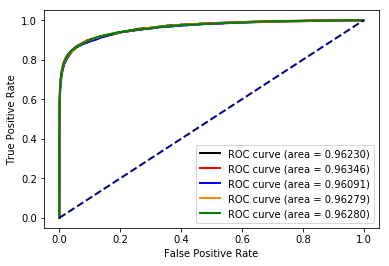

In [67]:
plt.figure()
lw = 2
colors = ['black','red','blue','darkorange','green']
for i in range(0,5):
    plt.plot(fprs_lgb[i], tprs_lgb[i], color=colors[i],
             lw=lw, label='ROC curve (area = %0.5f)' % scores_lgb[i][1])
    
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [68]:
scores_lgb

[(0.9860310650302202, 0.9623002661250216),
 (0.9858932139156581, 0.9634599087262266),
 (0.9858679147788002, 0.9609077022092841),
 (0.9858344752352028, 0.962785233595367),
 (0.985728714694919, 0.962803503256327)]

In [69]:
print('Mean AUC:', np.mean(scores_lgb,axis = 0))

Mean AUC: [0.98587108 0.96245132]


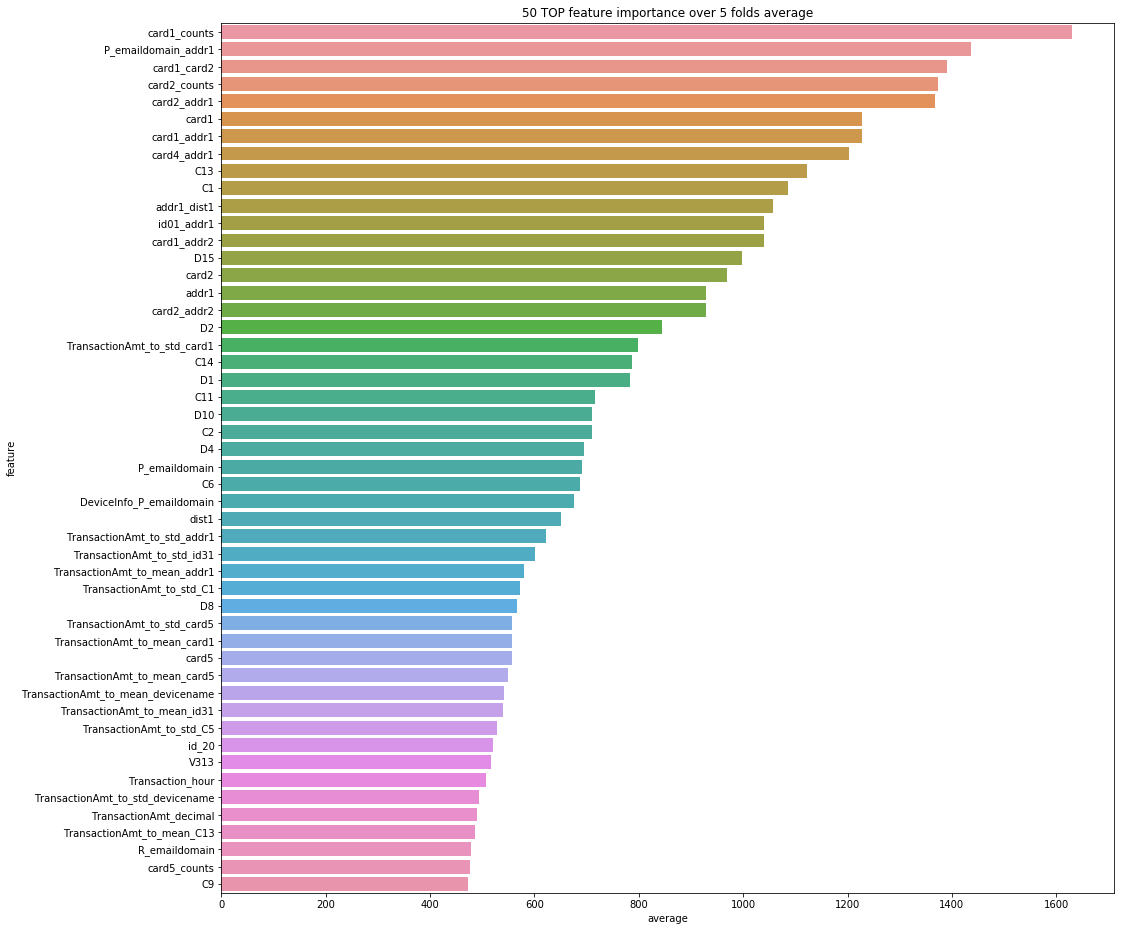

In [70]:
feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(cv.n_splits)]].mean(axis=1)
plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(cv.n_splits));

In [71]:
del train_data,target_data

In [72]:
data = {'TransactionID':transactionID,'isFraud':predictions}
submissionDF = pd.DataFrame(data)
submissionDF.to_csv('sample_submission.csv',index=False)